# **WGAN-GP: CelebA**  

**Data**  
> https://www.kaggle.com/jessicali9530/celeba-dataset  

In [18]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random

In [2]:
workers = 2
batch_size = 64
nz = 100
nc = 3
image_size = 64

epochs = 100
lr = 0.0001
beta1, beta2 = 0.5, 0.999
lamb = 10
n_critic = 5
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "./model"

print("Device: ", end="")
print(device)

Device: cuda:0


In [10]:
import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
    print("Already kaggle.json exsits.")
else:
    !mkdir -p ~/.kaggle
    !cp ./kaggle.json ~/.kaggle/ 
    !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset
if os.path.isdir('./img_align_celeba'):
    print("Already unzip.")
else:
    !unzip -q celeba-dataset.zip
    print("Unzip Complete!")

100%|██████████████████████████████████████▉| 1.33G/1.33G [00:13<00:00, 162MB/s]
100%|███████████████████████████████████████| 1.33G/1.33G [00:13<00:00, 103MB/s]
Unzip Complete!


In [3]:
dataset = datasets.ImageFolder(root='./img_align_celeba',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [4]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
    img = np.einsum('ijk->jki', img)
    img = (127.5*(img+1)).astype(np.uint8)
    return img

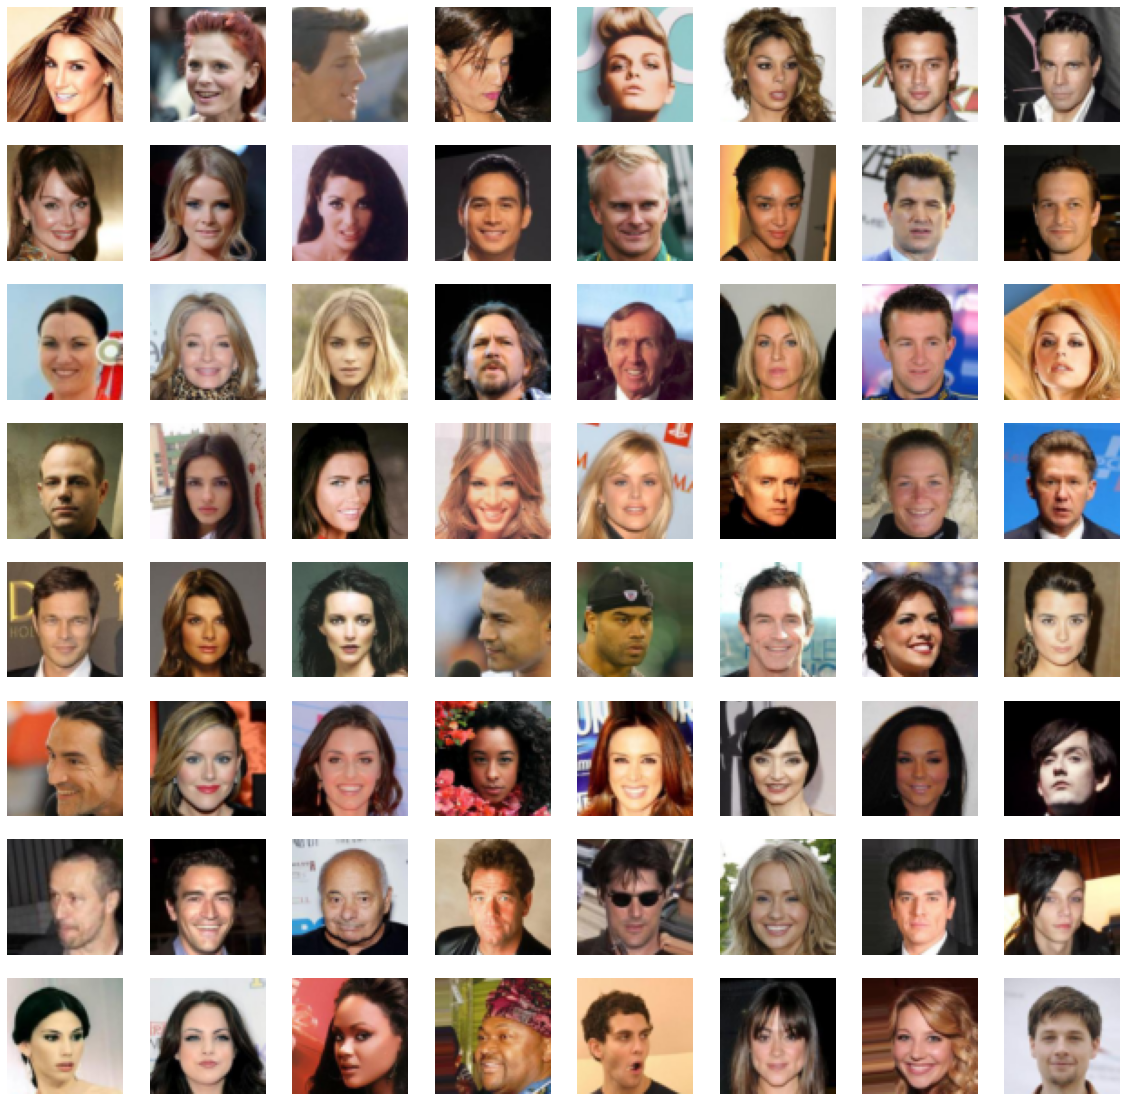

In [7]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
    img, idx = dataset[k]
    ax = fig.add_subplot(8, 8, k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")

plt.show()

## Generator  

1x1x(nz) → 4x4x1024 → 8x8x512 → 16x16x256 → 32x32x128 → 64x64x3

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 1 x 1 x nz
            nn.ConvTranspose2d(nz, 1024, 4, 1, 0, bias=False),
            nn.ReLU(inplace=True),
            # 4 x 4 x 1024
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 8 x 8 x 512
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 16 x 16 x 256
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 32 x 32 x 128
            nn.ConvTranspose2d(128, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 64 x 64 x nc
        )

    def forward(self, x):
        return self.main(x)

## Discriminator

64x64x3 → 32x32x64 → 16x16x128 → 8x8x256 → 4x4x512 → 1x1x1

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 64x64x3
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 32x32x64
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16x128
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8x256
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 4x4x512
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
            # 1x1x1
        )

    def forward(self, x):
        return self.main(x)

## Gradient Penalty

In [8]:
def calc_gradient_penalty(b_size, netD, real_data, fake_data):
    alpha = torch.rand(b_size, 1, 1, 1)
    alpha = alpha.cuda()

    interpolates = real_data + alpha * (fake_data - real_data)
    interpolates = Variable(interpolates, requires_grad=True).cuda()

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True)[0].view(interpolates.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamb
    
    return gradient_penalty

## Making models & Weight initialization

In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [23]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

## (Option) Load models and lists

In [10]:
model_name = 'WGAN-GP_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
noise_path = F"{model_saved_dir}/{model_name}_noise.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

with open(img_list_path, 'rb') as f:
    img_list = pickle.load(f)
with open(losses_path, 'rb') as f:
    G_losses, D_losses = pickle.load(f)
with open(noise_path, 'rb') as f:
    fixed_noise = pickle.load(f)

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))

<All keys matched successfully>

## Optimizers

In [11]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,beta2))

## Training

In [14]:
model_name = 'WGAN-GP_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
noise_path = F"{model_saved_dir}/{model_name}_noise.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

start_epoch = 42
continueTrain = False

if start_epoch == 0 and not continueTrain:
    img_list, G_losses, D_losses = [], [], []
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    with open(noise_path, 'wb') as f:
        pickle.dump(fixed_noise, f)
    
netD.train()
netG.train()

for ep in range(start_epoch, epochs):
    for batch_idx, (image, lbl) in enumerate(dataloader, 0):
        step = ep * len(dataloader) + batch_idx + 1

        b_size = image.shape[0]
        image = Variable(image).cuda()

        # 1. Update Discriminator
        output = netD(image).view(-1)
        errD_real = output.mean()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake.detach()).view(-1)
        errD_fake = output.mean()

        gradient_penalty = calc_gradient_penalty(b_size, netD, image, fake.detach())

        errD = errD_fake - errD_real + gradient_penalty

        netD.zero_grad()
        errD.backward()
        optimizerD.step() 

        # 2. Update Generator
        if step % n_critic == 0:        
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            output = netD(fake).view(-1)
            errG = -output.mean()

            netG.zero_grad()
            netD.zero_grad()
            errG.backward()
            optimizerG.step()

        if batch_idx % 50 == 49:
            print('[%3d/%3d][%4d/%4d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tGP: %.4f' 
                % (ep+1, epochs, batch_idx+1, len(dataloader), errD.item(), errG.item(), 
                   errD_real.item(), errD_fake.item(), -errG.item(), gradient_penalty.item()))
            G_losses.append(errG.item())
            D_losses.append(errD.item())
  
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(fake)

    torch.save(netG.state_dict(), G_path)
    torch.save(netD.state_dict(), D_path)

    with open(img_list_path, 'wb') as f:
        pickle.dump(img_list, f)
    with open(losses_path, 'wb') as f:
        pickle.dump((G_losses, D_losses), f)

[ 43/100][  50/3166]	Loss_D: -2.2493	Loss_G: 52.5843	D(x): -45.9593	D(G(z)): -48.3727 / -52.5843	GP: 0.1640
[ 43/100][ 100/3166]	Loss_D: -4.7756	Loss_G: 53.5063	D(x): -39.5433	D(G(z)): -44.4907 / -53.5063	GP: 0.1718
[ 43/100][ 150/3166]	Loss_D: -5.4342	Loss_G: 45.5860	D(x): -39.0626	D(G(z)): -46.1233 / -45.5860	GP: 1.6266
[ 43/100][ 200/3166]	Loss_D: -4.9724	Loss_G: 35.5840	D(x): -32.9784	D(G(z)): -38.0374 / -35.5840	GP: 0.0866
[ 43/100][ 250/3166]	Loss_D: -4.8367	Loss_G: 41.2274	D(x): -40.9704	D(G(z)): -45.8709 / -41.2274	GP: 0.0638
[ 43/100][ 300/3166]	Loss_D: -5.0574	Loss_G: 46.7422	D(x): -41.2796	D(G(z)): -46.5496 / -46.7422	GP: 0.2127
[ 43/100][ 350/3166]	Loss_D: -3.7451	Loss_G: 39.6091	D(x): -38.3484	D(G(z)): -42.2587 / -39.6091	GP: 0.1652
[ 43/100][ 400/3166]	Loss_D: 18.0994	Loss_G: 67.8735	D(x): -82.5999	D(G(z)): -75.0840 / -67.8735	GP: 10.5834
[ 43/100][ 450/3166]	Loss_D: -4.1217	Loss_G: 37.6333	D(x): -37.3344	D(G(z)): -41.6475 / -37.6333	GP: 0.1914
[ 43/100][ 500/3166]	Loss_D

[ 44/100][ 700/3166]	Loss_D: -0.4421	Loss_G: 38.6078	D(x): -38.1623	D(G(z)): -38.7038 / -38.6078	GP: 0.0994
[ 44/100][ 750/3166]	Loss_D: -0.8722	Loss_G: 38.1608	D(x): -37.0533	D(G(z)): -38.0078 / -38.1608	GP: 0.0823
[ 44/100][ 800/3166]	Loss_D: -0.1264	Loss_G: 38.1108	D(x): -37.0047	D(G(z)): -37.2019 / -38.1108	GP: 0.0708
[ 44/100][ 850/3166]	Loss_D: -1.1344	Loss_G: 37.6048	D(x): -36.4229	D(G(z)): -37.6111 / -37.6048	GP: 0.0537
[ 44/100][ 900/3166]	Loss_D: -0.6884	Loss_G: 36.6481	D(x): -35.8692	D(G(z)): -36.6078 / -36.6481	GP: 0.0501
[ 44/100][ 950/3166]	Loss_D: -0.8661	Loss_G: 36.5392	D(x): -35.3536	D(G(z)): -36.3092 / -36.5392	GP: 0.0895
[ 44/100][1000/3166]	Loss_D: -0.1838	Loss_G: 36.2096	D(x): -35.4243	D(G(z)): -35.6944 / -36.2096	GP: 0.0863
[ 44/100][1050/3166]	Loss_D: -1.0188	Loss_G: 35.1187	D(x): -34.2368	D(G(z)): -35.3140 / -35.1187	GP: 0.0584
[ 44/100][1100/3166]	Loss_D: -0.8113	Loss_G: 36.0958	D(x): -35.0582	D(G(z)): -35.9399 / -36.0958	GP: 0.0704
[ 44/100][1150/3166]	Loss_D:

[ 45/100][1350/3166]	Loss_D: -5.2086	Loss_G: 37.1682	D(x): -31.6066	D(G(z)): -37.6636 / -37.1682	GP: 0.8484
[ 45/100][1400/3166]	Loss_D: -4.1755	Loss_G: 36.2762	D(x): -35.0945	D(G(z)): -39.4044 / -36.2762	GP: 0.1344
[ 45/100][1450/3166]	Loss_D: -5.5012	Loss_G: 44.8708	D(x): -42.1946	D(G(z)): -48.0516 / -44.8708	GP: 0.3559
[ 45/100][1500/3166]	Loss_D: -2.6625	Loss_G: 36.2586	D(x): -33.5351	D(G(z)): -36.4300 / -36.2586	GP: 0.2324
[ 45/100][1550/3166]	Loss_D: -0.0694	Loss_G: 36.2391	D(x): -35.2032	D(G(z)): -35.3524 / -36.2391	GP: 0.0799
[ 45/100][1600/3166]	Loss_D: -0.0787	Loss_G: 35.8922	D(x): -34.9375	D(G(z)): -35.3941 / -35.8922	GP: 0.3780
[ 45/100][1650/3166]	Loss_D: -1.5621	Loss_G: 45.8072	D(x): -44.1452	D(G(z)): -46.2877 / -45.8072	GP: 0.5803
[ 45/100][1700/3166]	Loss_D: -5.2074	Loss_G: 35.7610	D(x): -30.2353	D(G(z)): -35.5775 / -35.7610	GP: 0.1348
[ 45/100][1750/3166]	Loss_D: -1.5920	Loss_G: 38.7274	D(x): -38.8803	D(G(z)): -40.5947 / -38.7274	GP: 0.1224
[ 45/100][1800/3166]	Loss_D:

[ 46/100][2000/3166]	Loss_D: -0.4486	Loss_G: 42.3936	D(x): -41.8219	D(G(z)): -42.3917 / -42.3936	GP: 0.1213
[ 46/100][2050/3166]	Loss_D: 0.3926	Loss_G: 40.9670	D(x): -41.0339	D(G(z)): -40.7650 / -40.9670	GP: 0.1237
[ 46/100][2100/3166]	Loss_D: -0.6186	Loss_G: 41.3928	D(x): -40.8913	D(G(z)): -41.6169 / -41.3928	GP: 0.1070
[ 46/100][2150/3166]	Loss_D: 0.5678	Loss_G: 41.2738	D(x): -42.0015	D(G(z)): -41.5789 / -41.2738	GP: 0.1452
[ 46/100][2200/3166]	Loss_D: 0.3591	Loss_G: 39.7669	D(x): -40.1359	D(G(z)): -39.8948 / -39.7669	GP: 0.1180
[ 46/100][2250/3166]	Loss_D: -0.4051	Loss_G: 38.9234	D(x): -38.2052	D(G(z)): -38.6823 / -38.9234	GP: 0.0719
[ 46/100][2300/3166]	Loss_D: -0.9840	Loss_G: 37.6594	D(x): -36.1334	D(G(z)): -37.1984 / -37.6594	GP: 0.0810
[ 46/100][2350/3166]	Loss_D: -0.9474	Loss_G: 36.4516	D(x): -35.5433	D(G(z)): -36.5765 / -36.4516	GP: 0.0858
[ 46/100][2400/3166]	Loss_D: -0.8266	Loss_G: 36.3117	D(x): -35.9034	D(G(z)): -36.8171 / -36.3117	GP: 0.0871
[ 46/100][2450/3166]	Loss_D: -0

[ 47/100][2650/3166]	Loss_D: -2.3315	Loss_G: 43.2863	D(x): -40.1868	D(G(z)): -42.6724 / -43.2863	GP: 0.1541
[ 47/100][2700/3166]	Loss_D: 0.3336	Loss_G: 44.3654	D(x): -42.4941	D(G(z)): -42.3564 / -44.3654	GP: 0.1958
[ 47/100][2750/3166]	Loss_D: 1.3094	Loss_G: 45.0451	D(x): -45.0842	D(G(z)): -43.8389 / -45.0451	GP: 0.0641
[ 47/100][2800/3166]	Loss_D: -3.3486	Loss_G: 41.9380	D(x): -36.9452	D(G(z)): -40.4807 / -41.9380	GP: 0.1870
[ 47/100][2850/3166]	Loss_D: -4.4447	Loss_G: 49.4616	D(x): -43.5271	D(G(z)): -48.1024 / -49.4616	GP: 0.1306
[ 47/100][2900/3166]	Loss_D: -1.9185	Loss_G: 42.1325	D(x): -39.6118	D(G(z)): -41.7148 / -42.1325	GP: 0.1845
[ 47/100][2950/3166]	Loss_D: -1.5226	Loss_G: 44.9642	D(x): -42.4141	D(G(z)): -44.1321 / -44.9642	GP: 0.1955
[ 47/100][3000/3166]	Loss_D: -2.6291	Loss_G: 42.9552	D(x): -38.4339	D(G(z)): -41.2352 / -42.9552	GP: 0.1721
[ 47/100][3050/3166]	Loss_D: -2.4646	Loss_G: 42.2244	D(x): -38.4957	D(G(z)): -41.9020 / -42.2244	GP: 0.9416
[ 47/100][3100/3166]	Loss_D: -

[ 49/100][ 150/3166]	Loss_D: -0.1150	Loss_G: 39.8646	D(x): -38.9146	D(G(z)): -39.1070 / -39.8646	GP: 0.0774
[ 49/100][ 200/3166]	Loss_D: 0.6250	Loss_G: 39.5682	D(x): -39.4037	D(G(z)): -38.9404 / -39.5682	GP: 0.1616
[ 49/100][ 250/3166]	Loss_D: -0.6410	Loss_G: 39.0337	D(x): -37.6745	D(G(z)): -38.4592 / -39.0337	GP: 0.1437
[ 49/100][ 300/3166]	Loss_D: -0.4903	Loss_G: 39.1310	D(x): -38.9183	D(G(z)): -39.4981 / -39.1310	GP: 0.0895
[ 49/100][ 350/3166]	Loss_D: -0.5023	Loss_G: 39.8704	D(x): -39.3822	D(G(z)): -39.9331 / -39.8704	GP: 0.0486
[ 49/100][ 400/3166]	Loss_D: -1.7131	Loss_G: 39.6035	D(x): -37.7816	D(G(z)): -39.5494 / -39.6035	GP: 0.0547
[ 49/100][ 450/3166]	Loss_D: -1.3599	Loss_G: 39.7367	D(x): -39.1057	D(G(z)): -40.5522 / -39.7367	GP: 0.0866
[ 49/100][ 500/3166]	Loss_D: -0.9468	Loss_G: 40.7346	D(x): -40.0000	D(G(z)): -41.0169 / -40.7346	GP: 0.0701
[ 49/100][ 550/3166]	Loss_D: -0.7919	Loss_G: 41.8676	D(x): -40.3244	D(G(z)): -41.1906 / -41.8676	GP: 0.0743
[ 49/100][ 600/3166]	Loss_D: 

[ 50/100][ 800/3166]	Loss_D: -1.4746	Loss_G: 47.7383	D(x): -45.5371	D(G(z)): -47.2080 / -47.7383	GP: 0.1964
[ 50/100][ 850/3166]	Loss_D: -4.1357	Loss_G: 44.8884	D(x): -40.5227	D(G(z)): -44.7191 / -44.8884	GP: 0.0607
[ 50/100][ 900/3166]	Loss_D: -0.6184	Loss_G: 48.6183	D(x): -48.5235	D(G(z)): -49.3273 / -48.6183	GP: 0.1854
[ 50/100][ 950/3166]	Loss_D: -2.5714	Loss_G: 45.7167	D(x): -43.8320	D(G(z)): -46.6115 / -45.7167	GP: 0.2081
[ 50/100][1000/3166]	Loss_D: -6.4097	Loss_G: 48.4629	D(x): -41.1684	D(G(z)): -47.8335 / -48.4629	GP: 0.2554
[ 50/100][1050/3166]	Loss_D: -2.5983	Loss_G: 46.5235	D(x): -46.4039	D(G(z)): -49.2195 / -46.5235	GP: 0.2172
[ 50/100][1100/3166]	Loss_D: -6.1223	Loss_G: 45.7303	D(x): -40.7548	D(G(z)): -47.3371 / -45.7303	GP: 0.4600
[ 50/100][1150/3166]	Loss_D: -5.8562	Loss_G: 49.7688	D(x): -45.9030	D(G(z)): -51.8103 / -49.7688	GP: 0.0512
[ 50/100][1200/3166]	Loss_D: -4.0206	Loss_G: 44.5569	D(x): -39.8072	D(G(z)): -44.2423 / -44.5569	GP: 0.4145
[ 50/100][1250/3166]	Loss_D:

[ 51/100][1450/3166]	Loss_D: -11.7007	Loss_G: 64.0982	D(x): -51.7673	D(G(z)): -64.0490 / -64.0982	GP: 0.5810
[ 51/100][1500/3166]	Loss_D: -3.8968	Loss_G: 39.7063	D(x): -34.1509	D(G(z)): -38.8152 / -39.7063	GP: 0.7674
[ 51/100][1550/3166]	Loss_D: 2.0067	Loss_G: 31.6686	D(x): -33.2754	D(G(z)): -31.4242 / -31.6686	GP: 0.1554
[ 51/100][1600/3166]	Loss_D: -1.7081	Loss_G: 42.6001	D(x): -40.1829	D(G(z)): -41.9620 / -42.6001	GP: 0.0711
[ 51/100][1650/3166]	Loss_D: -0.6864	Loss_G: 45.9028	D(x): -45.9824	D(G(z)): -46.7882 / -45.9028	GP: 0.1195
[ 51/100][1700/3166]	Loss_D: -3.3404	Loss_G: 40.2437	D(x): -36.1607	D(G(z)): -39.5355 / -40.2437	GP: 0.0344
[ 51/100][1750/3166]	Loss_D: -5.9343	Loss_G: 56.9271	D(x): -51.2708	D(G(z)): -58.2928 / -56.9271	GP: 1.0877
[ 51/100][1800/3166]	Loss_D: -4.2174	Loss_G: 48.9287	D(x): -47.6577	D(G(z)): -51.9662 / -48.9287	GP: 0.0911
[ 51/100][1850/3166]	Loss_D: -10.8768	Loss_G: 64.3884	D(x): -53.9844	D(G(z)): -65.3959 / -64.3884	GP: 0.5347
[ 51/100][1900/3166]	Loss_D

[ 52/100][2100/3166]	Loss_D: -3.1490	Loss_G: 51.0245	D(x): -48.3388	D(G(z)): -51.5558 / -51.0245	GP: 0.0679
[ 52/100][2150/3166]	Loss_D: -0.3030	Loss_G: 50.3958	D(x): -48.4086	D(G(z)): -49.2603 / -50.3958	GP: 0.5486
[ 52/100][2200/3166]	Loss_D: -0.4924	Loss_G: 55.4236	D(x): -54.4246	D(G(z)): -55.4514 / -55.4236	GP: 0.5345
[ 52/100][2250/3166]	Loss_D: -2.3254	Loss_G: 51.6049	D(x): -47.4041	D(G(z)): -50.1252 / -51.6049	GP: 0.3957
[ 52/100][2300/3166]	Loss_D: -3.5340	Loss_G: 46.5776	D(x): -42.0598	D(G(z)): -46.2018 / -46.5776	GP: 0.6080
[ 52/100][2350/3166]	Loss_D: -2.8421	Loss_G: 52.0711	D(x): -49.1458	D(G(z)): -52.1569 / -52.0711	GP: 0.1690
[ 52/100][2400/3166]	Loss_D: -3.4995	Loss_G: 46.8850	D(x): -42.9928	D(G(z)): -46.5712 / -46.8850	GP: 0.0790
[ 52/100][2450/3166]	Loss_D: -2.5192	Loss_G: 60.4491	D(x): -55.0834	D(G(z)): -58.9837 / -60.4491	GP: 1.3811
[ 52/100][2500/3166]	Loss_D: 3.8732	Loss_G: 49.0660	D(x): -44.9078	D(G(z)): -43.6525 / -49.0660	GP: 2.6178
[ 52/100][2550/3166]	Loss_D: 

[ 53/100][2750/3166]	Loss_D: 0.1232	Loss_G: 37.4572	D(x): -35.9749	D(G(z)): -35.9039 / -37.4572	GP: 0.0523
[ 53/100][2800/3166]	Loss_D: -4.5205	Loss_G: 40.1986	D(x): -34.1761	D(G(z)): -38.8085 / -40.1986	GP: 0.1119
[ 53/100][2850/3166]	Loss_D: -2.8515	Loss_G: 38.1854	D(x): -34.7595	D(G(z)): -37.8120 / -38.1854	GP: 0.2010
[ 53/100][2900/3166]	Loss_D: -5.7812	Loss_G: 42.6803	D(x): -37.0763	D(G(z)): -43.0465 / -42.6803	GP: 0.1890
[ 53/100][2950/3166]	Loss_D: 1.8827	Loss_G: 41.6140	D(x): -44.7353	D(G(z)): -43.0690 / -41.6140	GP: 0.2163
[ 53/100][3000/3166]	Loss_D: -4.0982	Loss_G: 47.4090	D(x): -41.7062	D(G(z)): -46.0284 / -47.4090	GP: 0.2241
[ 53/100][3050/3166]	Loss_D: -5.4877	Loss_G: 43.3001	D(x): -36.4984	D(G(z)): -42.2890 / -43.3001	GP: 0.3029
[ 53/100][3100/3166]	Loss_D: -8.5213	Loss_G: 45.2593	D(x): -37.4398	D(G(z)): -46.0520 / -45.2593	GP: 0.0909
[ 53/100][3150/3166]	Loss_D: -13.4292	Loss_G: 32.0147	D(x): -20.0616	D(G(z)): -33.5662 / -32.0147	GP: 0.0754
[ 54/100][  50/3166]	Loss_D: 

[ 55/100][ 250/3166]	Loss_D: -3.5288	Loss_G: 35.7882	D(x): -32.9202	D(G(z)): -36.5086 / -35.7882	GP: 0.0597
[ 55/100][ 300/3166]	Loss_D: -5.5440	Loss_G: 40.1657	D(x): -33.1414	D(G(z)): -39.4119 / -40.1657	GP: 0.7265
[ 55/100][ 350/3166]	Loss_D: -19.8604	Loss_G: 53.0649	D(x): -30.6316	D(G(z)): -50.7180 / -53.0649	GP: 0.2261
[ 55/100][ 400/3166]	Loss_D: -7.7791	Loss_G: 26.1851	D(x): -41.1649	D(G(z)): -49.0262 / -26.1851	GP: 0.0822
[ 55/100][ 450/3166]	Loss_D: -3.7775	Loss_G: 35.6753	D(x): -28.7230	D(G(z)): -33.5583 / -35.6753	GP: 1.0578
[ 55/100][ 500/3166]	Loss_D: -1.8344	Loss_G: 56.6132	D(x): -52.4891	D(G(z)): -56.4824 / -56.6132	GP: 2.1590
[ 55/100][ 550/3166]	Loss_D: -4.2877	Loss_G: 44.1867	D(x): -38.6241	D(G(z)): -43.0574 / -44.1867	GP: 0.1456
[ 55/100][ 600/3166]	Loss_D: -5.1262	Loss_G: 55.3988	D(x): -53.1822	D(G(z)): -58.4201 / -55.3988	GP: 0.1117
[ 55/100][ 650/3166]	Loss_D: 11.4426	Loss_G: 41.0696	D(x): -74.8751	D(G(z)): -80.5855 / -41.0696	GP: 17.1531
[ 55/100][ 700/3166]	Loss_

[ 56/100][ 900/3166]	Loss_D: -8.2085	Loss_G: 48.5919	D(x): -40.2668	D(G(z)): -48.6656 / -48.5919	GP: 0.1903
[ 56/100][ 950/3166]	Loss_D: -1.3663	Loss_G: 45.6393	D(x): -44.9761	D(G(z)): -46.4642 / -45.6393	GP: 0.1218
[ 56/100][1000/3166]	Loss_D: 0.9313	Loss_G: 53.9400	D(x): -52.6075	D(G(z)): -51.8339 / -53.9400	GP: 0.1577
[ 56/100][1050/3166]	Loss_D: -0.6116	Loss_G: 50.0019	D(x): -48.9993	D(G(z)): -49.6787 / -50.0019	GP: 0.0678
[ 56/100][1100/3166]	Loss_D: -0.8935	Loss_G: 49.2424	D(x): -47.7684	D(G(z)): -48.7348 / -49.2424	GP: 0.0729
[ 56/100][1150/3166]	Loss_D: -2.0661	Loss_G: 49.7071	D(x): -47.1593	D(G(z)): -49.2895 / -49.7071	GP: 0.0640
[ 56/100][1200/3166]	Loss_D: 0.5765	Loss_G: 50.1214	D(x): -49.6063	D(G(z)): -49.3063 / -50.1214	GP: 0.2765
[ 56/100][1250/3166]	Loss_D: -4.5302	Loss_G: 50.0979	D(x): -45.4997	D(G(z)): -50.3006 / -50.0979	GP: 0.2707
[ 56/100][1300/3166]	Loss_D: -4.4039	Loss_G: 49.3953	D(x): -46.1582	D(G(z)): -50.8591 / -49.3953	GP: 0.2970
[ 56/100][1350/3166]	Loss_D: 3

[ 57/100][1550/3166]	Loss_D: -2.2589	Loss_G: 42.2972	D(x): -37.1764	D(G(z)): -39.5162 / -42.2972	GP: 0.0808
[ 57/100][1600/3166]	Loss_D: -3.7143	Loss_G: 51.0602	D(x): -43.9192	D(G(z)): -47.8247 / -51.0602	GP: 0.1912
[ 57/100][1650/3166]	Loss_D: 0.1417	Loss_G: 51.7068	D(x): -51.2927	D(G(z)): -52.1269 / -51.7068	GP: 0.9759
[ 57/100][1700/3166]	Loss_D: -59.1774	Loss_G: 37.4967	D(x): 32.8831	D(G(z)): -30.4719 / -37.4967	GP: 4.1776
[ 57/100][1750/3166]	Loss_D: -15.4320	Loss_G: 71.2276	D(x): -48.0180	D(G(z)): -63.6243 / -71.2276	GP: 0.1742
[ 57/100][1800/3166]	Loss_D: -8.2590	Loss_G: 53.3861	D(x): -47.2994	D(G(z)): -56.5917 / -53.3861	GP: 1.0332
[ 57/100][1850/3166]	Loss_D: -11.3768	Loss_G: 52.4117	D(x): -38.8611	D(G(z)): -50.3048 / -52.4117	GP: 0.0670
[ 57/100][1900/3166]	Loss_D: 94.7556	Loss_G: 24.8649	D(x): -33.9056	D(G(z)): 59.6729 / -24.8649	GP: 1.1771
[ 57/100][1950/3166]	Loss_D: -24.6052	Loss_G: 29.2505	D(x): -6.4506	D(G(z)): -31.8709 / -29.2505	GP: 0.8151
[ 57/100][2000/3166]	Loss_D:

[ 58/100][2200/3166]	Loss_D: -2.3171	Loss_G: 43.2962	D(x): -40.0749	D(G(z)): -42.5042 / -43.2962	GP: 0.1122
[ 58/100][2250/3166]	Loss_D: -2.2027	Loss_G: 40.2920	D(x): -37.4148	D(G(z)): -39.7927 / -40.2920	GP: 0.1752
[ 58/100][2300/3166]	Loss_D: -0.8795	Loss_G: 42.2651	D(x): -43.6575	D(G(z)): -44.7849 / -42.2651	GP: 0.2480
[ 58/100][2350/3166]	Loss_D: -4.0569	Loss_G: 50.7795	D(x): -45.9935	D(G(z)): -50.2278 / -50.7795	GP: 0.1774
[ 58/100][2400/3166]	Loss_D: -2.0898	Loss_G: 44.9514	D(x): -44.3185	D(G(z)): -46.6173 / -44.9514	GP: 0.2090
[ 58/100][2450/3166]	Loss_D: -25.6370	Loss_G: 39.4621	D(x): -12.4419	D(G(z)): -39.1059 / -39.4621	GP: 1.0270
[ 58/100][2500/3166]	Loss_D: -3.5603	Loss_G: 43.4418	D(x): -42.0369	D(G(z)): -45.7189 / -43.4418	GP: 0.1217
[ 58/100][2550/3166]	Loss_D: -4.4804	Loss_G: 47.7068	D(x): -40.7807	D(G(z)): -45.3318 / -47.7068	GP: 0.0707
[ 58/100][2600/3166]	Loss_D: -1.4145	Loss_G: 34.2180	D(x): -32.1738	D(G(z)): -33.6770 / -34.2180	GP: 0.0887
[ 58/100][2650/3166]	Loss_D

[ 59/100][2850/3166]	Loss_D: -13.4076	Loss_G: 42.2876	D(x): -38.5553	D(G(z)): -52.0999 / -42.2876	GP: 0.1370
[ 59/100][2900/3166]	Loss_D: -2.8558	Loss_G: 26.3040	D(x): -23.0591	D(G(z)): -26.0366 / -26.3040	GP: 0.1217
[ 59/100][2950/3166]	Loss_D: -23.2297	Loss_G: 25.2073	D(x): -5.1675	D(G(z)): -28.4507 / -25.2073	GP: 0.0536
[ 59/100][3000/3166]	Loss_D: -62.5784	Loss_G: 27.2968	D(x): 39.2332	D(G(z)): -27.5372 / -27.2968	GP: 4.1920
[ 59/100][3050/3166]	Loss_D: 13.7788	Loss_G: 64.0004	D(x): -58.0396	D(G(z)): -63.3461 / -64.0004	GP: 19.0853
[ 59/100][3100/3166]	Loss_D: -5.9717	Loss_G: 34.5696	D(x): -29.7219	D(G(z)): -36.0486 / -34.5696	GP: 0.3550
[ 59/100][3150/3166]	Loss_D: -4.7268	Loss_G: 35.2013	D(x): -31.3733	D(G(z)): -36.1502 / -35.2013	GP: 0.0500
[ 60/100][  50/3166]	Loss_D: -4.6026	Loss_G: 29.9847	D(x): -23.0394	D(G(z)): -27.8466 / -29.9847	GP: 0.2045
[ 60/100][ 100/3166]	Loss_D: 8.4618	Loss_G: 22.8815	D(x): -38.6128	D(G(z)): -30.4680 / -22.8815	GP: 0.3170
[ 60/100][ 150/3166]	Loss_D

[ 61/100][ 350/3166]	Loss_D: -2.6761	Loss_G: 43.2426	D(x): -39.5295	D(G(z)): -42.3601 / -43.2426	GP: 0.1544
[ 61/100][ 400/3166]	Loss_D: -3.3314	Loss_G: 46.8255	D(x): -42.5623	D(G(z)): -45.9443 / -46.8255	GP: 0.0506
[ 61/100][ 450/3166]	Loss_D: -1.5314	Loss_G: 48.8716	D(x): -47.9220	D(G(z)): -49.5941 / -48.8716	GP: 0.1406
[ 61/100][ 500/3166]	Loss_D: -2.9515	Loss_G: 42.7457	D(x): -40.0532	D(G(z)): -43.1289 / -42.7457	GP: 0.1242
[ 61/100][ 550/3166]	Loss_D: -2.1701	Loss_G: 44.8789	D(x): -43.1961	D(G(z)): -45.4287 / -44.8789	GP: 0.0625
[ 61/100][ 600/3166]	Loss_D: -2.2772	Loss_G: 47.0259	D(x): -43.1942	D(G(z)): -45.6294 / -47.0259	GP: 0.1580
[ 61/100][ 650/3166]	Loss_D: -4.0087	Loss_G: 50.0101	D(x): -44.8375	D(G(z)): -48.9831 / -50.0101	GP: 0.1369
[ 61/100][ 700/3166]	Loss_D: -1.2909	Loss_G: 44.2268	D(x): -40.0469	D(G(z)): -41.5593 / -44.2268	GP: 0.2215
[ 61/100][ 750/3166]	Loss_D: -4.7787	Loss_G: 45.8406	D(x): -42.1162	D(G(z)): -47.0024 / -45.8406	GP: 0.1075
[ 61/100][ 800/3166]	Loss_D:

[ 62/100][1000/3166]	Loss_D: -0.6746	Loss_G: 39.0638	D(x): -37.4335	D(G(z)): -38.1915 / -39.0638	GP: 0.0833
[ 62/100][1050/3166]	Loss_D: -0.3424	Loss_G: 38.1754	D(x): -37.7359	D(G(z)): -38.1245 / -38.1754	GP: 0.0462
[ 62/100][1100/3166]	Loss_D: 0.0812	Loss_G: 38.5241	D(x): -37.9039	D(G(z)): -37.8905 / -38.5241	GP: 0.0678
[ 62/100][1150/3166]	Loss_D: -0.1541	Loss_G: 38.1947	D(x): -38.2776	D(G(z)): -38.5160 / -38.1947	GP: 0.0842
[ 62/100][1200/3166]	Loss_D: -0.8802	Loss_G: 39.6867	D(x): -39.7966	D(G(z)): -40.7582 / -39.6867	GP: 0.0813
[ 62/100][1250/3166]	Loss_D: 0.0163	Loss_G: 39.7713	D(x): -40.1479	D(G(z)): -40.2288 / -39.7713	GP: 0.0972
[ 62/100][1300/3166]	Loss_D: -2.2655	Loss_G: 40.7110	D(x): -38.5846	D(G(z)): -40.9281 / -40.7110	GP: 0.0781
[ 62/100][1350/3166]	Loss_D: 0.1878	Loss_G: 41.6669	D(x): -40.5789	D(G(z)): -40.4678 / -41.6669	GP: 0.0766
[ 62/100][1400/3166]	Loss_D: -0.9400	Loss_G: 38.7685	D(x): -39.2262	D(G(z)): -40.2241 / -38.7685	GP: 0.0579
[ 62/100][1450/3166]	Loss_D: -0

[ 63/100][1650/3166]	Loss_D: -2.2856	Loss_G: 44.4163	D(x): -41.7889	D(G(z)): -44.1277 / -44.4163	GP: 0.0532
[ 63/100][1700/3166]	Loss_D: -3.1155	Loss_G: 43.8887	D(x): -41.9320	D(G(z)): -45.4100 / -43.8887	GP: 0.3625
[ 63/100][1750/3166]	Loss_D: -0.5128	Loss_G: 36.1427	D(x): -34.8138	D(G(z)): -36.1223 / -36.1427	GP: 0.7957
[ 63/100][1800/3166]	Loss_D: -2.4076	Loss_G: 40.3494	D(x): -38.3728	D(G(z)): -40.8402 / -40.3494	GP: 0.0597
[ 63/100][1850/3166]	Loss_D: -0.3362	Loss_G: 42.5056	D(x): -41.5521	D(G(z)): -42.0754 / -42.5056	GP: 0.1871
[ 63/100][1900/3166]	Loss_D: -2.7854	Loss_G: 40.1567	D(x): -36.7686	D(G(z)): -39.6452 / -40.1567	GP: 0.0912
[ 63/100][1950/3166]	Loss_D: -1.3264	Loss_G: 40.3921	D(x): -38.6151	D(G(z)): -39.9715 / -40.3921	GP: 0.0301
[ 63/100][2000/3166]	Loss_D: -1.9917	Loss_G: 44.5042	D(x): -41.2728	D(G(z)): -43.3753 / -44.5042	GP: 0.1108
[ 63/100][2050/3166]	Loss_D: -3.2089	Loss_G: 40.0809	D(x): -36.3776	D(G(z)): -39.7873 / -40.0809	GP: 0.2008
[ 63/100][2100/3166]	Loss_D:

[ 64/100][2300/3166]	Loss_D: -1.3566	Loss_G: 30.2308	D(x): -28.6797	D(G(z)): -30.1035 / -30.2308	GP: 0.0672
[ 64/100][2350/3166]	Loss_D: -0.5246	Loss_G: 39.3624	D(x): -36.0927	D(G(z)): -36.6823 / -39.3624	GP: 0.0650
[ 64/100][2400/3166]	Loss_D: -4.5475	Loss_G: 35.7635	D(x): -31.3795	D(G(z)): -36.0052 / -35.7635	GP: 0.0782
[ 64/100][2450/3166]	Loss_D: -1.0436	Loss_G: 36.8648	D(x): -37.1969	D(G(z)): -38.2803 / -36.8648	GP: 0.0398
[ 64/100][2500/3166]	Loss_D: -5.7569	Loss_G: 47.7073	D(x): -41.0334	D(G(z)): -46.8928 / -47.7073	GP: 0.1026
[ 64/100][2550/3166]	Loss_D: -3.6435	Loss_G: 41.5783	D(x): -36.8989	D(G(z)): -40.6310 / -41.5783	GP: 0.0886
[ 64/100][2600/3166]	Loss_D: -5.4406	Loss_G: 40.5725	D(x): -42.3132	D(G(z)): -48.4576 / -40.5725	GP: 0.7037
[ 64/100][2650/3166]	Loss_D: -0.4364	Loss_G: 42.0917	D(x): -45.3135	D(G(z)): -45.9685 / -42.0917	GP: 0.2186
[ 64/100][2700/3166]	Loss_D: 0.1230	Loss_G: 35.9651	D(x): -30.7382	D(G(z)): -31.0864 / -35.9651	GP: 0.4712
[ 64/100][2750/3166]	Loss_D: 

[ 65/100][2950/3166]	Loss_D: -4.0880	Loss_G: 52.2266	D(x): -48.0966	D(G(z)): -52.3911 / -52.2266	GP: 0.2064
[ 65/100][3000/3166]	Loss_D: -0.8299	Loss_G: 50.5529	D(x): -48.3312	D(G(z)): -49.4471 / -50.5529	GP: 0.2859
[ 65/100][3050/3166]	Loss_D: 0.5635	Loss_G: 49.0907	D(x): -48.1490	D(G(z)): -47.8674 / -49.0907	GP: 0.2819
[ 65/100][3100/3166]	Loss_D: 1.1628	Loss_G: 49.0188	D(x): -49.0070	D(G(z)): -47.9453 / -49.0188	GP: 0.1011
[ 65/100][3150/3166]	Loss_D: -0.7604	Loss_G: 47.7938	D(x): -47.2983	D(G(z)): -48.1857 / -47.7938	GP: 0.1270
[ 66/100][  50/3166]	Loss_D: -0.1395	Loss_G: 44.4178	D(x): -44.2304	D(G(z)): -44.4661 / -44.4178	GP: 0.0962
[ 66/100][ 100/3166]	Loss_D: -1.7487	Loss_G: 42.3711	D(x): -40.1427	D(G(z)): -41.9648 / -42.3711	GP: 0.0734
[ 66/100][ 150/3166]	Loss_D: -0.7433	Loss_G: 41.2941	D(x): -39.9668	D(G(z)): -40.7721 / -41.2941	GP: 0.0620
[ 66/100][ 200/3166]	Loss_D: -1.5940	Loss_G: 41.9720	D(x): -40.5931	D(G(z)): -42.2443 / -41.9720	GP: 0.0572
[ 66/100][ 250/3166]	Loss_D: -

[ 67/100][ 450/3166]	Loss_D: -9.6273	Loss_G: 59.9817	D(x): -50.8488	D(G(z)): -60.6625 / -59.9817	GP: 0.1865
[ 67/100][ 500/3166]	Loss_D: -2.0101	Loss_G: 39.3948	D(x): -32.7752	D(G(z)): -35.4578 / -39.3948	GP: 0.6724
[ 67/100][ 550/3166]	Loss_D: -0.6426	Loss_G: 48.1486	D(x): -43.8675	D(G(z)): -44.5789 / -48.1486	GP: 0.0687
[ 67/100][ 600/3166]	Loss_D: -4.4313	Loss_G: 42.7092	D(x): -34.4277	D(G(z)): -39.1876 / -42.7092	GP: 0.3287
[ 67/100][ 650/3166]	Loss_D: -4.5350	Loss_G: 41.2540	D(x): -31.0262	D(G(z)): -36.1508 / -41.2540	GP: 0.5896
[ 67/100][ 700/3166]	Loss_D: 18.4287	Loss_G: 44.4736	D(x): -48.1995	D(G(z)): -30.5529 / -44.4736	GP: 0.7821
[ 67/100][ 750/3166]	Loss_D: -3.0870	Loss_G: 33.8525	D(x): -31.5922	D(G(z)): -34.8283 / -33.8525	GP: 0.1491
[ 67/100][ 800/3166]	Loss_D: 1.3242	Loss_G: 31.2456	D(x): -32.0319	D(G(z)): -30.9413 / -31.2456	GP: 0.2336
[ 67/100][ 850/3166]	Loss_D: -2.3188	Loss_G: 41.0816	D(x): -37.7564	D(G(z)): -40.3547 / -41.0816	GP: 0.2795
[ 67/100][ 900/3166]	Loss_D: 

[ 68/100][1100/3166]	Loss_D: -3.2118	Loss_G: 49.0095	D(x): -46.8965	D(G(z)): -50.1971 / -49.0095	GP: 0.0888
[ 68/100][1150/3166]	Loss_D: 1.6047	Loss_G: 42.5898	D(x): -44.0034	D(G(z)): -42.8465 / -42.5898	GP: 0.4477
[ 68/100][1200/3166]	Loss_D: -4.2156	Loss_G: 53.5930	D(x): -43.9313	D(G(z)): -48.6101 / -53.5930	GP: 0.4632
[ 68/100][1250/3166]	Loss_D: -1.9791	Loss_G: 46.8998	D(x): -44.0453	D(G(z)): -46.6954 / -46.8998	GP: 0.6711
[ 68/100][1300/3166]	Loss_D: -0.8223	Loss_G: 45.8481	D(x): -40.5137	D(G(z)): -41.4689 / -45.8481	GP: 0.1330
[ 68/100][1350/3166]	Loss_D: -3.9434	Loss_G: 40.9456	D(x): -38.3737	D(G(z)): -42.4218 / -40.9456	GP: 0.1047
[ 68/100][1400/3166]	Loss_D: -0.1036	Loss_G: 44.7157	D(x): -38.2613	D(G(z)): -38.5250 / -44.7157	GP: 0.1601
[ 68/100][1450/3166]	Loss_D: -4.4200	Loss_G: 46.2710	D(x): -43.5793	D(G(z)): -48.4066 / -46.2710	GP: 0.4073
[ 68/100][1500/3166]	Loss_D: -3.2801	Loss_G: 37.3670	D(x): -30.5608	D(G(z)): -35.8736 / -37.3670	GP: 2.0328
[ 68/100][1550/3166]	Loss_D: 

[ 69/100][1750/3166]	Loss_D: -4.9862	Loss_G: 32.1647	D(x): -26.0734	D(G(z)): -31.2030 / -32.1647	GP: 0.1433
[ 69/100][1800/3166]	Loss_D: 0.8179	Loss_G: 56.7376	D(x): -48.0919	D(G(z)): -47.9237 / -56.7376	GP: 0.6496
[ 69/100][1850/3166]	Loss_D: -1.4496	Loss_G: 46.6614	D(x): -45.6033	D(G(z)): -47.3399 / -46.6614	GP: 0.2870
[ 69/100][1900/3166]	Loss_D: -3.1149	Loss_G: 50.1086	D(x): -36.4068	D(G(z)): -39.7191 / -50.1086	GP: 0.1975
[ 69/100][1950/3166]	Loss_D: -6.1036	Loss_G: 29.3272	D(x): -16.1963	D(G(z)): -22.5084 / -29.3272	GP: 0.2085
[ 69/100][2000/3166]	Loss_D: -12.0753	Loss_G: 28.8572	D(x): -14.7678	D(G(z)): -30.0905 / -28.8572	GP: 3.2474
[ 69/100][2050/3166]	Loss_D: -6.8120	Loss_G: 65.3467	D(x): -54.4243	D(G(z)): -61.3063 / -65.3467	GP: 0.0700
[ 69/100][2100/3166]	Loss_D: -3.4314	Loss_G: 50.4673	D(x): -46.5248	D(G(z)): -50.0124 / -50.4673	GP: 0.0562
[ 69/100][2150/3166]	Loss_D: -8.4122	Loss_G: 53.7027	D(x): -38.3434	D(G(z)): -46.9215 / -53.7027	GP: 0.1659
[ 69/100][2200/3166]	Loss_D:

[ 70/100][2400/3166]	Loss_D: 1.5281	Loss_G: 42.6074	D(x): -44.5159	D(G(z)): -43.1201 / -42.6074	GP: 0.1323
[ 70/100][2450/3166]	Loss_D: -0.9873	Loss_G: 43.6773	D(x): -42.5245	D(G(z)): -43.6215 / -43.6773	GP: 0.1096
[ 70/100][2500/3166]	Loss_D: -0.8842	Loss_G: 44.9935	D(x): -43.7660	D(G(z)): -44.7122 / -44.9935	GP: 0.0620
[ 70/100][2550/3166]	Loss_D: -1.6164	Loss_G: 45.8910	D(x): -43.9078	D(G(z)): -45.6101 / -45.8910	GP: 0.0859
[ 70/100][2600/3166]	Loss_D: -0.0404	Loss_G: 44.9511	D(x): -44.1390	D(G(z)): -44.2548 / -44.9511	GP: 0.0755
[ 70/100][2650/3166]	Loss_D: -1.3687	Loss_G: 45.0173	D(x): -43.3871	D(G(z)): -44.8398 / -45.0173	GP: 0.0840
[ 70/100][2700/3166]	Loss_D: 0.2896	Loss_G: 44.3041	D(x): -45.3696	D(G(z)): -45.1970 / -44.3041	GP: 0.1170
[ 70/100][2750/3166]	Loss_D: 0.2123	Loss_G: 44.5865	D(x): -44.1464	D(G(z)): -44.0083 / -44.5865	GP: 0.0743
[ 70/100][2800/3166]	Loss_D: -0.4957	Loss_G: 44.9874	D(x): -43.9484	D(G(z)): -44.5206 / -44.9874	GP: 0.0764
[ 70/100][2850/3166]	Loss_D: -1

[ 71/100][3050/3166]	Loss_D: -1.4450	Loss_G: 47.8604	D(x): -45.0594	D(G(z)): -46.5878 / -47.8604	GP: 0.0834
[ 71/100][3100/3166]	Loss_D: -2.5697	Loss_G: 45.5641	D(x): -43.3451	D(G(z)): -45.9815 / -45.5641	GP: 0.0666
[ 71/100][3150/3166]	Loss_D: -2.0408	Loss_G: 52.8365	D(x): -48.1453	D(G(z)): -50.3964 / -52.8365	GP: 0.2103
[ 72/100][  50/3166]	Loss_D: -0.5601	Loss_G: 41.7412	D(x): -39.2079	D(G(z)): -39.8722 / -41.7412	GP: 0.1041
[ 72/100][ 100/3166]	Loss_D: -3.0113	Loss_G: 44.3167	D(x): -41.3671	D(G(z)): -44.6617 / -44.3167	GP: 0.2834
[ 72/100][ 150/3166]	Loss_D: -0.0143	Loss_G: 46.7400	D(x): -41.2502	D(G(z)): -41.4445 / -46.7400	GP: 0.1800
[ 72/100][ 200/3166]	Loss_D: 1.9605	Loss_G: 41.5782	D(x): -37.9123	D(G(z)): -36.2131 / -41.5782	GP: 0.2613
[ 72/100][ 250/3166]	Loss_D: -4.8654	Loss_G: 48.0718	D(x): -43.1202	D(G(z)): -48.3560 / -48.0718	GP: 0.3704
[ 72/100][ 300/3166]	Loss_D: -0.5118	Loss_G: 34.6207	D(x): -34.9207	D(G(z)): -35.4936 / -34.6207	GP: 0.0610
[ 72/100][ 350/3166]	Loss_D: 

[ 73/100][ 550/3166]	Loss_D: -3.4131	Loss_G: 59.0073	D(x): -54.2594	D(G(z)): -57.8040 / -59.0073	GP: 0.1316
[ 73/100][ 600/3166]	Loss_D: 12.4433	Loss_G: 50.8464	D(x): -49.5984	D(G(z)): -37.7311 / -50.8464	GP: 0.5760
[ 73/100][ 650/3166]	Loss_D: -4.6756	Loss_G: 42.7843	D(x): -31.2985	D(G(z)): -42.2058 / -42.7843	GP: 6.2317
[ 73/100][ 700/3166]	Loss_D: -8.3135	Loss_G: 54.8951	D(x): -42.8897	D(G(z)): -51.2866 / -54.8951	GP: 0.0834
[ 73/100][ 750/3166]	Loss_D: -5.5649	Loss_G: 51.5015	D(x): -50.4164	D(G(z)): -57.0787 / -51.5015	GP: 1.0974
[ 73/100][ 800/3166]	Loss_D: -7.5970	Loss_G: 47.4910	D(x): -37.5119	D(G(z)): -45.2919 / -47.4910	GP: 0.1831
[ 73/100][ 850/3166]	Loss_D: -2.5882	Loss_G: 56.4305	D(x): -49.9701	D(G(z)): -52.9079 / -56.4305	GP: 0.3497
[ 73/100][ 900/3166]	Loss_D: -2.2628	Loss_G: 41.9680	D(x): -45.1656	D(G(z)): -47.7723 / -41.9680	GP: 0.3439
[ 73/100][ 950/3166]	Loss_D: -5.6570	Loss_G: 46.6597	D(x): -43.0425	D(G(z)): -48.7630 / -46.6597	GP: 0.0635
[ 73/100][1000/3166]	Loss_D:

[ 74/100][1200/3166]	Loss_D: -1.3661	Loss_G: 44.8682	D(x): -43.7238	D(G(z)): -45.1596 / -44.8682	GP: 0.0697
[ 74/100][1250/3166]	Loss_D: -0.6188	Loss_G: 45.8143	D(x): -44.6831	D(G(z)): -45.3420 / -45.8143	GP: 0.0401
[ 74/100][1300/3166]	Loss_D: -1.3974	Loss_G: 45.4476	D(x): -44.7166	D(G(z)): -46.1479 / -45.4476	GP: 0.0339
[ 74/100][1350/3166]	Loss_D: -0.1232	Loss_G: 44.6405	D(x): -43.3101	D(G(z)): -43.5543 / -44.6405	GP: 0.1210
[ 74/100][1400/3166]	Loss_D: -0.1049	Loss_G: 42.5236	D(x): -41.8976	D(G(z)): -42.0641 / -42.5236	GP: 0.0617
[ 74/100][1450/3166]	Loss_D: -2.0898	Loss_G: 41.0454	D(x): -39.2606	D(G(z)): -41.4130 / -41.0454	GP: 0.0625
[ 74/100][1500/3166]	Loss_D: -0.8778	Loss_G: 40.9082	D(x): -40.0980	D(G(z)): -41.0189 / -40.9082	GP: 0.0432
[ 74/100][1550/3166]	Loss_D: -1.0168	Loss_G: 40.3784	D(x): -40.6708	D(G(z)): -41.7360 / -40.3784	GP: 0.0484
[ 74/100][1600/3166]	Loss_D: -1.6394	Loss_G: 44.1820	D(x): -42.1699	D(G(z)): -43.8598 / -44.1820	GP: 0.0505
[ 74/100][1650/3166]	Loss_D:

[ 75/100][1850/3166]	Loss_D: 3.0780	Loss_G: 45.2118	D(x): -40.7600	D(G(z)): -38.5436 / -45.2118	GP: 0.8616
[ 75/100][1900/3166]	Loss_D: 2.1084	Loss_G: 78.0350	D(x): -53.7384	D(G(z)): -51.7092 / -78.0350	GP: 0.0793
[ 75/100][1950/3166]	Loss_D: -15.7099	Loss_G: 50.5342	D(x): -16.7019	D(G(z)): -33.6565 / -50.5342	GP: 1.2447
[ 75/100][2000/3166]	Loss_D: -52.3883	Loss_G: 27.4044	D(x): 23.7269	D(G(z)): -32.9410 / -27.4044	GP: 4.2796
[ 75/100][2050/3166]	Loss_D: -13.7417	Loss_G: 50.9649	D(x): -47.5572	D(G(z)): -61.3975 / -50.9649	GP: 0.0985
[ 75/100][2100/3166]	Loss_D: -1.9381	Loss_G: 52.1301	D(x): -47.1296	D(G(z)): -49.1465 / -52.1301	GP: 0.0788
[ 75/100][2150/3166]	Loss_D: -6.0610	Loss_G: 71.0939	D(x): -45.8259	D(G(z)): -52.1819 / -71.0939	GP: 0.2950
[ 75/100][2200/3166]	Loss_D: 10.6376	Loss_G: 33.4108	D(x): -38.5600	D(G(z)): -29.8568 / -33.4108	GP: 1.9344
[ 75/100][2250/3166]	Loss_D: -2.7657	Loss_G: 38.2649	D(x): -31.2034	D(G(z)): -34.5314 / -38.2649	GP: 0.5623
[ 75/100][2300/3166]	Loss_D:

[ 76/100][2500/3166]	Loss_D: -8.1926	Loss_G: 48.6176	D(x): -38.7095	D(G(z)): -47.1901 / -48.6176	GP: 0.2879
[ 76/100][2550/3166]	Loss_D: -4.6301	Loss_G: 31.9707	D(x): -31.3207	D(G(z)): -36.0916 / -31.9707	GP: 0.1408
[ 76/100][2600/3166]	Loss_D: -8.2673	Loss_G: 46.8196	D(x): -45.6363	D(G(z)): -54.1348 / -46.8196	GP: 0.2312
[ 76/100][2650/3166]	Loss_D: -3.9816	Loss_G: 46.9334	D(x): -45.8561	D(G(z)): -50.3639 / -46.9334	GP: 0.5261
[ 76/100][2700/3166]	Loss_D: 6.3204	Loss_G: 48.2201	D(x): -32.6072	D(G(z)): -27.9689 / -48.2201	GP: 1.6821
[ 76/100][2750/3166]	Loss_D: -2.5468	Loss_G: 47.3151	D(x): -29.4234	D(G(z)): -33.8752 / -47.3151	GP: 1.9050
[ 76/100][2800/3166]	Loss_D: -2.6339	Loss_G: 65.1007	D(x): -63.7249	D(G(z)): -66.5704 / -65.1007	GP: 0.2117
[ 76/100][2850/3166]	Loss_D: 1.3207	Loss_G: 54.8965	D(x): -54.1830	D(G(z)): -53.0212 / -54.8965	GP: 0.1589
[ 76/100][2900/3166]	Loss_D: -1.7779	Loss_G: 45.8132	D(x): -44.8729	D(G(z)): -46.7431 / -45.8132	GP: 0.0923
[ 76/100][2950/3166]	Loss_D: -

[ 77/100][3150/3166]	Loss_D: -3.3585	Loss_G: 44.5480	D(x): -41.1651	D(G(z)): -44.6417 / -44.5480	GP: 0.1181
[ 78/100][  50/3166]	Loss_D: -0.4942	Loss_G: 47.1333	D(x): -46.3251	D(G(z)): -46.9087 / -47.1333	GP: 0.0894
[ 78/100][ 100/3166]	Loss_D: -1.6361	Loss_G: 47.0227	D(x): -45.0942	D(G(z)): -46.8054 / -47.0227	GP: 0.0751
[ 78/100][ 150/3166]	Loss_D: -1.0596	Loss_G: 47.6911	D(x): -45.0375	D(G(z)): -46.4803 / -47.6911	GP: 0.3831
[ 78/100][ 200/3166]	Loss_D: -1.8284	Loss_G: 51.3100	D(x): -48.8419	D(G(z)): -50.7044 / -51.3100	GP: 0.0341
[ 78/100][ 250/3166]	Loss_D: 0.3198	Loss_G: 50.6934	D(x): -51.7088	D(G(z)): -51.9024 / -50.6934	GP: 0.5135
[ 78/100][ 300/3166]	Loss_D: -0.9861	Loss_G: 49.7394	D(x): -48.6434	D(G(z)): -49.9420 / -49.7394	GP: 0.3125
[ 78/100][ 350/3166]	Loss_D: -6.1749	Loss_G: 48.3689	D(x): -41.4443	D(G(z)): -47.8291 / -48.3689	GP: 0.2099
[ 78/100][ 400/3166]	Loss_D: -9.7575	Loss_G: 56.1441	D(x): -47.9309	D(G(z)): -57.7384 / -56.1441	GP: 0.0500
[ 78/100][ 450/3166]	Loss_D: 

[ 79/100][ 650/3166]	Loss_D: -0.4632	Loss_G: 40.7841	D(x): -39.7729	D(G(z)): -40.3143 / -40.7841	GP: 0.0782
[ 79/100][ 700/3166]	Loss_D: -1.2576	Loss_G: 40.2246	D(x): -38.0492	D(G(z)): -39.3593 / -40.2246	GP: 0.0525
[ 79/100][ 750/3166]	Loss_D: -0.9585	Loss_G: 39.1061	D(x): -37.5670	D(G(z)): -38.5623 / -39.1061	GP: 0.0369
[ 79/100][ 800/3166]	Loss_D: 0.5679	Loss_G: 38.1482	D(x): -38.5720	D(G(z)): -38.0636 / -38.1482	GP: 0.0595
[ 79/100][ 850/3166]	Loss_D: 0.0519	Loss_G: 38.3955	D(x): -37.4587	D(G(z)): -37.5849 / -38.3955	GP: 0.1781
[ 79/100][ 900/3166]	Loss_D: -1.3702	Loss_G: 38.4684	D(x): -37.8039	D(G(z)): -39.3736 / -38.4684	GP: 0.1995
[ 79/100][ 950/3166]	Loss_D: -0.1079	Loss_G: 39.1177	D(x): -38.7012	D(G(z)): -38.8859 / -39.1177	GP: 0.0768
[ 79/100][1000/3166]	Loss_D: -0.9415	Loss_G: 39.5558	D(x): -39.3645	D(G(z)): -40.3661 / -39.5558	GP: 0.0601
[ 79/100][1050/3166]	Loss_D: 0.0385	Loss_G: 41.3258	D(x): -40.4759	D(G(z)): -40.5189 / -41.3258	GP: 0.0815
[ 79/100][1100/3166]	Loss_D: -0

[ 80/100][1300/3166]	Loss_D: -2.7245	Loss_G: 55.7030	D(x): -54.4554	D(G(z)): -57.4678 / -55.7030	GP: 0.2879
[ 80/100][1350/3166]	Loss_D: -2.7634	Loss_G: 47.8975	D(x): -45.0829	D(G(z)): -47.8982 / -47.8975	GP: 0.0519
[ 80/100][1400/3166]	Loss_D: -3.1797	Loss_G: 45.2341	D(x): -45.2900	D(G(z)): -48.5168 / -45.2341	GP: 0.0472
[ 80/100][1450/3166]	Loss_D: -1.3193	Loss_G: 49.6235	D(x): -47.0489	D(G(z)): -48.4203 / -49.6235	GP: 0.0521
[ 80/100][1500/3166]	Loss_D: -3.1393	Loss_G: 52.0376	D(x): -42.8684	D(G(z)): -46.0843 / -52.0376	GP: 0.0767
[ 80/100][1550/3166]	Loss_D: 0.3473	Loss_G: 46.7912	D(x): -40.4629	D(G(z)): -40.2806 / -46.7912	GP: 0.1650
[ 80/100][1600/3166]	Loss_D: -14.1507	Loss_G: 45.9778	D(x): -31.9716	D(G(z)): -46.2019 / -45.9778	GP: 0.0795
[ 80/100][1650/3166]	Loss_D: -28.6856	Loss_G: 28.3782	D(x): 4.2589	D(G(z)): -28.1070 / -28.3782	GP: 3.6803
[ 80/100][1700/3166]	Loss_D: -1.9668	Loss_G: 63.2126	D(x): -61.4202	D(G(z)): -63.8139 / -63.2126	GP: 0.4270
[ 80/100][1750/3166]	Loss_D: 

[ 81/100][1950/3166]	Loss_D: -3.7665	Loss_G: 57.7364	D(x): -50.3529	D(G(z)): -54.9145 / -57.7364	GP: 0.7950
[ 81/100][2000/3166]	Loss_D: -2.8097	Loss_G: 41.7023	D(x): -39.3535	D(G(z)): -42.3665 / -41.7023	GP: 0.2034
[ 81/100][2050/3166]	Loss_D: 1.8565	Loss_G: 44.9209	D(x): -38.6788	D(G(z)): -39.1502 / -44.9209	GP: 2.3279
[ 81/100][2100/3166]	Loss_D: -4.7554	Loss_G: 43.6920	D(x): -35.4131	D(G(z)): -40.3618 / -43.6920	GP: 0.1933
[ 81/100][2150/3166]	Loss_D: -8.6023	Loss_G: 39.0886	D(x): -33.8324	D(G(z)): -42.5527 / -39.0886	GP: 0.1180
[ 81/100][2200/3166]	Loss_D: -37.4182	Loss_G: 78.7016	D(x): -50.5173	D(G(z)): -88.3604 / -78.7016	GP: 0.4249
[ 81/100][2250/3166]	Loss_D: -7.3576	Loss_G: 28.7990	D(x): -18.8293	D(G(z)): -27.4976 / -28.7990	GP: 1.3107
[ 81/100][2300/3166]	Loss_D: -6.7301	Loss_G: 47.1773	D(x): -41.0118	D(G(z)): -48.2733 / -47.1773	GP: 0.5314
[ 81/100][2350/3166]	Loss_D: -4.2651	Loss_G: 45.6905	D(x): -42.3747	D(G(z)): -47.0103 / -45.6905	GP: 0.3705
[ 81/100][2400/3166]	Loss_D:

[ 82/100][2600/3166]	Loss_D: -1.6924	Loss_G: 60.3971	D(x): -53.5060	D(G(z)): -57.5220 / -60.3971	GP: 2.3237
[ 82/100][2650/3166]	Loss_D: -2.1507	Loss_G: 59.7500	D(x): -53.4289	D(G(z)): -56.9323 / -59.7500	GP: 1.3527
[ 82/100][2700/3166]	Loss_D: -33.6342	Loss_G: 39.9099	D(x): -3.8108	D(G(z)): -38.9233 / -39.9099	GP: 1.4783
[ 82/100][2750/3166]	Loss_D: -3.2826	Loss_G: 72.4090	D(x): -52.8664	D(G(z)): -56.6204 / -72.4090	GP: 0.4714
[ 82/100][2800/3166]	Loss_D: -25.0266	Loss_G: 19.4355	D(x): 7.6351	D(G(z)): -25.5121 / -19.4355	GP: 8.1205
[ 82/100][2850/3166]	Loss_D: 11.8235	Loss_G: 44.8664	D(x): -35.2856	D(G(z)): -30.9842 / -44.8664	GP: 7.5221
[ 82/100][2900/3166]	Loss_D: 1.9049	Loss_G: 22.4625	D(x): -22.4415	D(G(z)): -20.6585 / -22.4625	GP: 0.1220
[ 82/100][2950/3166]	Loss_D: -2.1113	Loss_G: 32.5072	D(x): -30.9991	D(G(z)): -33.2684 / -32.5072	GP: 0.1580
[ 82/100][3000/3166]	Loss_D: -1.2895	Loss_G: 36.1786	D(x): -34.4307	D(G(z)): -35.8379 / -36.1786	GP: 0.1177
[ 82/100][3050/3166]	Loss_D: -

[ 84/100][ 100/3166]	Loss_D: -0.5958	Loss_G: 39.7657	D(x): -38.9707	D(G(z)): -39.5911 / -39.7657	GP: 0.0247
[ 84/100][ 150/3166]	Loss_D: -1.8683	Loss_G: 44.3848	D(x): -41.5987	D(G(z)): -43.6298 / -44.3848	GP: 0.1628
[ 84/100][ 200/3166]	Loss_D: -1.8910	Loss_G: 47.6041	D(x): -44.1514	D(G(z)): -46.1544 / -47.6041	GP: 0.1120
[ 84/100][ 250/3166]	Loss_D: 0.4133	Loss_G: 43.2004	D(x): -41.8691	D(G(z)): -41.4856 / -43.2004	GP: 0.0298
[ 84/100][ 300/3166]	Loss_D: -2.1319	Loss_G: 41.6067	D(x): -39.3006	D(G(z)): -41.4733 / -41.6067	GP: 0.0408
[ 84/100][ 350/3166]	Loss_D: -3.3937	Loss_G: 36.1790	D(x): -31.5775	D(G(z)): -35.0502 / -36.1790	GP: 0.0791
[ 84/100][ 400/3166]	Loss_D: -2.5122	Loss_G: 41.5634	D(x): -39.9890	D(G(z)): -42.5357 / -41.5634	GP: 0.0345
[ 84/100][ 450/3166]	Loss_D: -5.7749	Loss_G: 43.4731	D(x): -37.6957	D(G(z)): -43.5032 / -43.4731	GP: 0.0326
[ 84/100][ 500/3166]	Loss_D: -0.4601	Loss_G: 44.5936	D(x): -44.9044	D(G(z)): -45.6364 / -44.5936	GP: 0.2719
[ 84/100][ 550/3166]	Loss_D: 

[ 85/100][ 750/3166]	Loss_D: 0.9477	Loss_G: 45.8796	D(x): -29.9024	D(G(z)): -31.4774 / -45.8796	GP: 2.5227
[ 85/100][ 800/3166]	Loss_D: -3.6606	Loss_G: 63.6151	D(x): -59.6330	D(G(z)): -64.4112 / -63.6151	GP: 1.1176
[ 85/100][ 850/3166]	Loss_D: -0.1273	Loss_G: 60.7092	D(x): -60.1174	D(G(z)): -60.3192 / -60.7092	GP: 0.0745
[ 85/100][ 900/3166]	Loss_D: -0.1761	Loss_G: 58.2461	D(x): -58.4768	D(G(z)): -58.7068 / -58.2461	GP: 0.0539
[ 85/100][ 950/3166]	Loss_D: -0.3174	Loss_G: 53.4972	D(x): -52.0575	D(G(z)): -52.4421 / -53.4972	GP: 0.0672
[ 85/100][1000/3166]	Loss_D: -0.7360	Loss_G: 48.8357	D(x): -46.4540	D(G(z)): -47.3042 / -48.8357	GP: 0.1142
[ 85/100][1050/3166]	Loss_D: 0.1190	Loss_G: 48.0389	D(x): -45.9170	D(G(z)): -45.8710 / -48.0389	GP: 0.0731
[ 85/100][1100/3166]	Loss_D: -1.3205	Loss_G: 42.6705	D(x): -41.6543	D(G(z)): -43.0468 / -42.6705	GP: 0.0720
[ 85/100][1150/3166]	Loss_D: -0.8056	Loss_G: 41.3009	D(x): -41.6824	D(G(z)): -42.5551 / -41.3009	GP: 0.0672
[ 85/100][1200/3166]	Loss_D: -

[ 86/100][1400/3166]	Loss_D: -3.5493	Loss_G: 49.8898	D(x): -47.1984	D(G(z)): -50.8492 / -49.8898	GP: 0.1015
[ 86/100][1450/3166]	Loss_D: -1.8910	Loss_G: 46.6535	D(x): -46.2460	D(G(z)): -48.5635 / -46.6535	GP: 0.4264
[ 86/100][1500/3166]	Loss_D: -3.5576	Loss_G: 41.6383	D(x): -38.8363	D(G(z)): -42.4466 / -41.6383	GP: 0.0527
[ 86/100][1550/3166]	Loss_D: -3.2185	Loss_G: 37.5707	D(x): -35.5980	D(G(z)): -38.8546 / -37.5707	GP: 0.0381
[ 86/100][1600/3166]	Loss_D: -4.0637	Loss_G: 52.2054	D(x): -45.2294	D(G(z)): -50.0214 / -52.2054	GP: 0.7283
[ 86/100][1650/3166]	Loss_D: -4.2076	Loss_G: 42.7823	D(x): -36.8524	D(G(z)): -41.1448 / -42.7823	GP: 0.0847
[ 86/100][1700/3166]	Loss_D: -5.0417	Loss_G: 68.0211	D(x): -64.2986	D(G(z)): -72.0950 / -68.0211	GP: 2.7547
[ 86/100][1750/3166]	Loss_D: 0.5648	Loss_G: 49.4858	D(x): -52.1064	D(G(z)): -51.6082 / -49.4858	GP: 0.0666
[ 86/100][1800/3166]	Loss_D: -1.2869	Loss_G: 46.3413	D(x): -40.4908	D(G(z)): -41.9845 / -46.3413	GP: 0.2068
[ 86/100][1850/3166]	Loss_D: 

[ 87/100][2050/3166]	Loss_D: -3.1805	Loss_G: 45.2899	D(x): -43.2852	D(G(z)): -46.5312 / -45.2899	GP: 0.0655
[ 87/100][2100/3166]	Loss_D: -3.5183	Loss_G: 49.6193	D(x): -44.7962	D(G(z)): -48.3648 / -49.6193	GP: 0.0502
[ 87/100][2150/3166]	Loss_D: -1.3575	Loss_G: 47.8098	D(x): -45.2302	D(G(z)): -46.6160 / -47.8098	GP: 0.0282
[ 87/100][2200/3166]	Loss_D: -1.4479	Loss_G: 49.2408	D(x): -47.0507	D(G(z)): -48.8162 / -49.2408	GP: 0.3177
[ 87/100][2250/3166]	Loss_D: -2.0232	Loss_G: 47.3442	D(x): -45.3257	D(G(z)): -47.4036 / -47.3442	GP: 0.0547
[ 87/100][2300/3166]	Loss_D: -0.8424	Loss_G: 43.6777	D(x): -42.1958	D(G(z)): -43.1019 / -43.6777	GP: 0.0637
[ 87/100][2350/3166]	Loss_D: -2.1909	Loss_G: 52.0638	D(x): -48.1718	D(G(z)): -50.4204 / -52.0638	GP: 0.0578
[ 87/100][2400/3166]	Loss_D: -0.2946	Loss_G: 48.1623	D(x): -46.5023	D(G(z)): -46.8529 / -48.1623	GP: 0.0560
[ 87/100][2450/3166]	Loss_D: 1.7501	Loss_G: 44.3556	D(x): -43.9885	D(G(z)): -42.4810 / -44.3556	GP: 0.2426
[ 87/100][2500/3166]	Loss_D: 

[ 88/100][2700/3166]	Loss_D: -0.1984	Loss_G: 36.2829	D(x): -36.0471	D(G(z)): -36.3377 / -36.2829	GP: 0.0922
[ 88/100][2750/3166]	Loss_D: -0.3162	Loss_G: 36.1935	D(x): -36.0413	D(G(z)): -36.4165 / -36.1935	GP: 0.0590
[ 88/100][2800/3166]	Loss_D: -0.5190	Loss_G: 36.4605	D(x): -36.1362	D(G(z)): -36.7189 / -36.4605	GP: 0.0636
[ 88/100][2850/3166]	Loss_D: -0.9593	Loss_G: 37.0328	D(x): -35.9443	D(G(z)): -36.9815 / -37.0328	GP: 0.0778
[ 88/100][2900/3166]	Loss_D: -0.7004	Loss_G: 37.4992	D(x): -36.6043	D(G(z)): -37.3649 / -37.4992	GP: 0.0602
[ 88/100][2950/3166]	Loss_D: -0.2843	Loss_G: 37.2046	D(x): -36.7159	D(G(z)): -37.0629 / -37.2046	GP: 0.0627
[ 88/100][3000/3166]	Loss_D: -0.5190	Loss_G: 36.1785	D(x): -35.9161	D(G(z)): -36.5456 / -36.1785	GP: 0.1106
[ 88/100][3050/3166]	Loss_D: -0.4026	Loss_G: 36.8269	D(x): -36.6692	D(G(z)): -37.2013 / -36.8269	GP: 0.1295
[ 88/100][3100/3166]	Loss_D: -0.5291	Loss_G: 38.1510	D(x): -37.2592	D(G(z)): -37.8659 / -38.1510	GP: 0.0776
[ 88/100][3150/3166]	Loss_D:

[ 90/100][ 200/3166]	Loss_D: -1.5769	Loss_G: 43.2271	D(x): -40.8127	D(G(z)): -42.5497 / -43.2271	GP: 0.1601
[ 90/100][ 250/3166]	Loss_D: -0.3640	Loss_G: 41.9340	D(x): -42.0320	D(G(z)): -42.6341 / -41.9340	GP: 0.2381
[ 90/100][ 300/3166]	Loss_D: -2.6436	Loss_G: 38.3819	D(x): -35.2074	D(G(z)): -38.3839 / -38.3819	GP: 0.5329
[ 90/100][ 350/3166]	Loss_D: 0.0390	Loss_G: 38.0009	D(x): -37.4135	D(G(z)): -37.6040 / -38.0009	GP: 0.2295
[ 90/100][ 400/3166]	Loss_D: -0.6262	Loss_G: 43.6667	D(x): -41.0469	D(G(z)): -42.0398 / -43.6667	GP: 0.3667
[ 90/100][ 450/3166]	Loss_D: 0.2166	Loss_G: 38.2600	D(x): -36.6799	D(G(z)): -36.5405 / -38.2600	GP: 0.0771
[ 90/100][ 500/3166]	Loss_D: -1.4708	Loss_G: 46.5726	D(x): -44.0535	D(G(z)): -45.6444 / -46.5726	GP: 0.1201
[ 90/100][ 550/3166]	Loss_D: -1.3262	Loss_G: 43.0077	D(x): -39.7457	D(G(z)): -41.2090 / -43.0077	GP: 0.1371
[ 90/100][ 600/3166]	Loss_D: -1.3191	Loss_G: 39.8734	D(x): -37.6411	D(G(z)): -39.1187 / -39.8734	GP: 0.1586
[ 90/100][ 650/3166]	Loss_D: 1

[ 91/100][ 850/3166]	Loss_D: -4.1731	Loss_G: 59.6139	D(x): -54.2352	D(G(z)): -58.6713 / -59.6139	GP: 0.2630
[ 91/100][ 900/3166]	Loss_D: -3.0269	Loss_G: 51.0960	D(x): -49.3161	D(G(z)): -52.4355 / -51.0960	GP: 0.0925
[ 91/100][ 950/3166]	Loss_D: -8.3486	Loss_G: 42.8274	D(x): -38.4327	D(G(z)): -47.1217 / -42.8274	GP: 0.3403
[ 91/100][1000/3166]	Loss_D: -4.8947	Loss_G: 55.0050	D(x): -47.2007	D(G(z)): -52.2150 / -55.0050	GP: 0.1195
[ 91/100][1050/3166]	Loss_D: -3.3640	Loss_G: 59.0058	D(x): -54.2032	D(G(z)): -57.8771 / -59.0058	GP: 0.3099
[ 91/100][1100/3166]	Loss_D: -3.5156	Loss_G: 40.0444	D(x): -36.4042	D(G(z)): -41.5085 / -40.0444	GP: 1.5886
[ 91/100][1150/3166]	Loss_D: 0.6319	Loss_G: 54.4497	D(x): -77.7383	D(G(z)): -82.1616 / -54.4497	GP: 5.0552
[ 91/100][1200/3166]	Loss_D: -1.9529	Loss_G: 54.4055	D(x): -51.2442	D(G(z)): -53.3265 / -54.4055	GP: 0.1294
[ 91/100][1250/3166]	Loss_D: -25.4923	Loss_G: 24.7568	D(x): -1.3777	D(G(z)): -30.5314 / -24.7568	GP: 3.6614
[ 91/100][1300/3166]	Loss_D: 

[ 92/100][1500/3166]	Loss_D: 3.0378	Loss_G: 45.1234	D(x): -43.6651	D(G(z)): -40.7397 / -45.1234	GP: 0.1124
[ 92/100][1550/3166]	Loss_D: -11.8591	Loss_G: 32.9518	D(x): -23.2329	D(G(z)): -35.9732 / -32.9518	GP: 0.8813
[ 92/100][1600/3166]	Loss_D: -5.1425	Loss_G: 38.8093	D(x): -33.0855	D(G(z)): -38.3271 / -38.8093	GP: 0.0992
[ 92/100][1650/3166]	Loss_D: -5.5823	Loss_G: 50.7958	D(x): -42.4498	D(G(z)): -48.4964 / -50.7958	GP: 0.4643
[ 92/100][1700/3166]	Loss_D: -7.9642	Loss_G: 58.0360	D(x): -47.5274	D(G(z)): -55.9428 / -58.0360	GP: 0.4512
[ 92/100][1750/3166]	Loss_D: -2.6702	Loss_G: 43.8829	D(x): -40.4669	D(G(z)): -43.2118 / -43.8829	GP: 0.0747
[ 92/100][1800/3166]	Loss_D: -6.6336	Loss_G: 40.9546	D(x): -32.9947	D(G(z)): -39.8899 / -40.9546	GP: 0.2615
[ 92/100][1850/3166]	Loss_D: -7.8370	Loss_G: 29.0685	D(x): -20.8423	D(G(z)): -28.8829 / -29.0685	GP: 0.2035
[ 92/100][1900/3166]	Loss_D: -4.5601	Loss_G: 29.9876	D(x): -27.3983	D(G(z)): -32.1986 / -29.9876	GP: 0.2401
[ 92/100][1950/3166]	Loss_D:

[ 93/100][2150/3166]	Loss_D: 33.7293	Loss_G: 28.4721	D(x): 11.2366	D(G(z)): 9.9829 / -28.4721	GP: 34.9829
[ 93/100][2200/3166]	Loss_D: -3.0694	Loss_G: 44.3134	D(x): -41.1219	D(G(z)): -44.2939 / -44.3134	GP: 0.1026
[ 93/100][2250/3166]	Loss_D: -9.9649	Loss_G: 49.7519	D(x): -45.5632	D(G(z)): -55.6409 / -49.7519	GP: 0.1128
[ 93/100][2300/3166]	Loss_D: -2.5630	Loss_G: 41.9883	D(x): -41.6476	D(G(z)): -44.2972 / -41.9883	GP: 0.0867
[ 93/100][2350/3166]	Loss_D: 5.4532	Loss_G: 36.2556	D(x): -34.3997	D(G(z)): -31.3416 / -36.2556	GP: 2.3951
[ 93/100][2400/3166]	Loss_D: -2.5021	Loss_G: 36.2692	D(x): -32.9514	D(G(z)): -36.0763 / -36.2692	GP: 0.6227
[ 93/100][2450/3166]	Loss_D: -4.3744	Loss_G: 44.4128	D(x): -47.3594	D(G(z)): -52.0245 / -44.4128	GP: 0.2906
[ 93/100][2500/3166]	Loss_D: -4.6899	Loss_G: 27.1416	D(x): -24.3248	D(G(z)): -29.9250 / -27.1416	GP: 0.9103
[ 93/100][2550/3166]	Loss_D: -1.5035	Loss_G: 55.6450	D(x): -52.2716	D(G(z)): -54.0094 / -55.6450	GP: 0.2343
[ 93/100][2600/3166]	Loss_D: -2

[ 94/100][2800/3166]	Loss_D: -2.8727	Loss_G: 50.5135	D(x): -48.4826	D(G(z)): -51.4034 / -50.5135	GP: 0.0481
[ 94/100][2850/3166]	Loss_D: -2.6832	Loss_G: 50.5450	D(x): -46.5123	D(G(z)): -49.2311 / -50.5450	GP: 0.0356
[ 94/100][2900/3166]	Loss_D: 0.0197	Loss_G: 46.4985	D(x): -45.1790	D(G(z)): -45.1921 / -46.4985	GP: 0.0329
[ 94/100][2950/3166]	Loss_D: -1.6831	Loss_G: 42.8256	D(x): -40.2537	D(G(z)): -41.9951 / -42.8256	GP: 0.0583
[ 94/100][3000/3166]	Loss_D: -3.2782	Loss_G: 43.9312	D(x): -40.0004	D(G(z)): -43.3784 / -43.9312	GP: 0.0998
[ 94/100][3050/3166]	Loss_D: -1.6941	Loss_G: 46.3573	D(x): -45.2383	D(G(z)): -46.9680 / -46.3573	GP: 0.0356
[ 94/100][3100/3166]	Loss_D: -3.7463	Loss_G: 47.5995	D(x): -43.3674	D(G(z)): -47.2129 / -47.5995	GP: 0.0992
[ 94/100][3150/3166]	Loss_D: -3.7651	Loss_G: 50.5049	D(x): -47.1460	D(G(z)): -51.2567 / -50.5049	GP: 0.3457
[ 95/100][  50/3166]	Loss_D: -2.1394	Loss_G: 53.7617	D(x): -51.8622	D(G(z)): -54.0435 / -53.7617	GP: 0.0419
[ 95/100][ 100/3166]	Loss_D: 

[ 96/100][ 300/3166]	Loss_D: -1.8438	Loss_G: 46.8153	D(x): -37.8743	D(G(z)): -39.8251 / -46.8153	GP: 0.1071
[ 96/100][ 350/3166]	Loss_D: -11.4968	Loss_G: 42.8069	D(x): -28.0834	D(G(z)): -40.5853 / -42.8069	GP: 1.0051
[ 96/100][ 400/3166]	Loss_D: -0.9677	Loss_G: 43.2402	D(x): -41.4718	D(G(z)): -42.4938 / -43.2402	GP: 0.0543
[ 96/100][ 450/3166]	Loss_D: -129.2263	Loss_G: 163.9968	D(x): -34.2924	D(G(z)): -164.0399 / -163.9968	GP: 0.5211
[ 96/100][ 500/3166]	Loss_D: 0.0448	Loss_G: 32.6965	D(x): -31.6925	D(G(z)): -33.0697 / -32.6965	GP: 1.4221
[ 96/100][ 550/3166]	Loss_D: -8.4072	Loss_G: 51.3524	D(x): -45.6154	D(G(z)): -54.7510 / -51.3524	GP: 0.7284
[ 96/100][ 600/3166]	Loss_D: -24.7856	Loss_G: 52.1650	D(x): -26.7839	D(G(z)): -53.0191 / -52.1650	GP: 1.4495
[ 96/100][ 650/3166]	Loss_D: -5.5087	Loss_G: 49.3282	D(x): -48.8516	D(G(z)): -54.8041 / -49.3282	GP: 0.4438
[ 96/100][ 700/3166]	Loss_D: -5.9723	Loss_G: 67.7900	D(x): -58.5391	D(G(z)): -64.7897 / -67.7900	GP: 0.2783
[ 96/100][ 750/3166]	L

[ 97/100][ 950/3166]	Loss_D: -3.2021	Loss_G: 45.8268	D(x): -41.1001	D(G(z)): -44.4981 / -45.8268	GP: 0.1959
[ 97/100][1000/3166]	Loss_D: -2.3692	Loss_G: 45.4245	D(x): -45.7215	D(G(z)): -48.4391 / -45.4245	GP: 0.3484
[ 97/100][1050/3166]	Loss_D: -8.0193	Loss_G: 50.6650	D(x): -44.7317	D(G(z)): -52.9143 / -50.6650	GP: 0.1633
[ 97/100][1100/3166]	Loss_D: 4.1586	Loss_G: 55.6259	D(x): -51.0258	D(G(z)): -50.3525 / -55.6259	GP: 3.4854
[ 97/100][1150/3166]	Loss_D: -22.7455	Loss_G: 42.5891	D(x): -14.0491	D(G(z)): -37.7293 / -42.5891	GP: 0.9347
[ 97/100][1200/3166]	Loss_D: 17.6187	Loss_G: 51.5218	D(x): -48.4460	D(G(z)): -31.0415 / -51.5218	GP: 0.2142
[ 97/100][1250/3166]	Loss_D: 6.6038	Loss_G: 47.6265	D(x): -45.5068	D(G(z)): -40.0277 / -47.6265	GP: 1.1247
[ 97/100][1300/3166]	Loss_D: -0.1261	Loss_G: 42.9082	D(x): -39.2167	D(G(z)): -39.4279 / -42.9082	GP: 0.0851
[ 97/100][1350/3166]	Loss_D: -4.8526	Loss_G: 35.1455	D(x): -32.5516	D(G(z)): -37.4549 / -35.1455	GP: 0.0506
[ 97/100][1400/3166]	Loss_D: 

[ 98/100][1600/3166]	Loss_D: -3.0576	Loss_G: 52.7938	D(x): -52.2873	D(G(z)): -55.4182 / -52.7938	GP: 0.0734
[ 98/100][1650/3166]	Loss_D: -0.5962	Loss_G: 47.5866	D(x): -44.1060	D(G(z)): -44.9564 / -47.5866	GP: 0.2542
[ 98/100][1700/3166]	Loss_D: -7.1945	Loss_G: 44.8875	D(x): -36.9817	D(G(z)): -44.6323 / -44.8875	GP: 0.4560
[ 98/100][1750/3166]	Loss_D: 4.1046	Loss_G: 44.7467	D(x): -46.9080	D(G(z)): -43.0822 / -44.7467	GP: 0.2788
[ 98/100][1800/3166]	Loss_D: -8.7337	Loss_G: 54.3238	D(x): -53.2553	D(G(z)): -62.0986 / -54.3238	GP: 0.1096
[ 98/100][1850/3166]	Loss_D: -4.1495	Loss_G: 39.0469	D(x): -40.1807	D(G(z)): -44.4433 / -39.0469	GP: 0.1131
[ 98/100][1900/3166]	Loss_D: -3.6704	Loss_G: 53.9005	D(x): -50.3363	D(G(z)): -54.1931 / -53.9005	GP: 0.1864
[ 98/100][1950/3166]	Loss_D: 1.3516	Loss_G: 32.2662	D(x): -32.9933	D(G(z)): -31.7820 / -32.2662	GP: 0.1403
[ 98/100][2000/3166]	Loss_D: -1.4192	Loss_G: 34.8084	D(x): -32.4230	D(G(z)): -33.8934 / -34.8084	GP: 0.0512
[ 98/100][2050/3166]	Loss_D: -

[ 99/100][2250/3166]	Loss_D: -3.3096	Loss_G: 72.9126	D(x): -52.7760	D(G(z)): -56.1272 / -72.9126	GP: 0.0416
[ 99/100][2300/3166]	Loss_D: -0.0146	Loss_G: 45.5292	D(x): -40.1456	D(G(z)): -40.3677 / -45.5292	GP: 0.2075
[ 99/100][2350/3166]	Loss_D: 3.4615	Loss_G: 52.7992	D(x): -56.6396	D(G(z)): -53.6311 / -52.7992	GP: 0.4531
[ 99/100][2400/3166]	Loss_D: 12.4771	Loss_G: 21.9776	D(x): -36.1137	D(G(z)): -27.3266 / -21.9776	GP: 3.6900
[ 99/100][2450/3166]	Loss_D: -17.6635	Loss_G: 53.4601	D(x): -28.5865	D(G(z)): -46.5610 / -53.4601	GP: 0.3110
[ 99/100][2500/3166]	Loss_D: -2.0750	Loss_G: 52.7438	D(x): -52.0712	D(G(z)): -54.1929 / -52.7438	GP: 0.0467
[ 99/100][2550/3166]	Loss_D: -7.7443	Loss_G: 55.0439	D(x): -44.9459	D(G(z)): -53.9501 / -55.0439	GP: 1.2599
[ 99/100][2600/3166]	Loss_D: -4.2822	Loss_G: 49.0080	D(x): -44.8771	D(G(z)): -49.3505 / -49.0080	GP: 0.1913
[ 99/100][2650/3166]	Loss_D: -2.1791	Loss_G: 40.8598	D(x): -36.9561	D(G(z)): -39.2571 / -40.8598	GP: 0.1219
[ 99/100][2700/3166]	Loss_D:

[100/100][2900/3166]	Loss_D: -5.1520	Loss_G: 50.8762	D(x): -48.6325	D(G(z)): -53.8623 / -50.8762	GP: 0.0778
[100/100][2950/3166]	Loss_D: -0.4161	Loss_G: 44.5474	D(x): -40.0050	D(G(z)): -42.2090 / -44.5474	GP: 1.7879
[100/100][3000/3166]	Loss_D: 4.1548	Loss_G: 53.3612	D(x): -45.3975	D(G(z)): -43.5941 / -53.3612	GP: 2.3515
[100/100][3050/3166]	Loss_D: -6.3487	Loss_G: 66.5114	D(x): -49.5470	D(G(z)): -56.1409 / -66.5114	GP: 0.2452
[100/100][3100/3166]	Loss_D: -5.8289	Loss_G: 58.5366	D(x): -52.4258	D(G(z)): -58.6066 / -58.5366	GP: 0.3519
[100/100][3150/3166]	Loss_D: -36.0101	Loss_G: 59.5602	D(x): -16.3749	D(G(z)): -52.8449 / -59.5602	GP: 0.4598


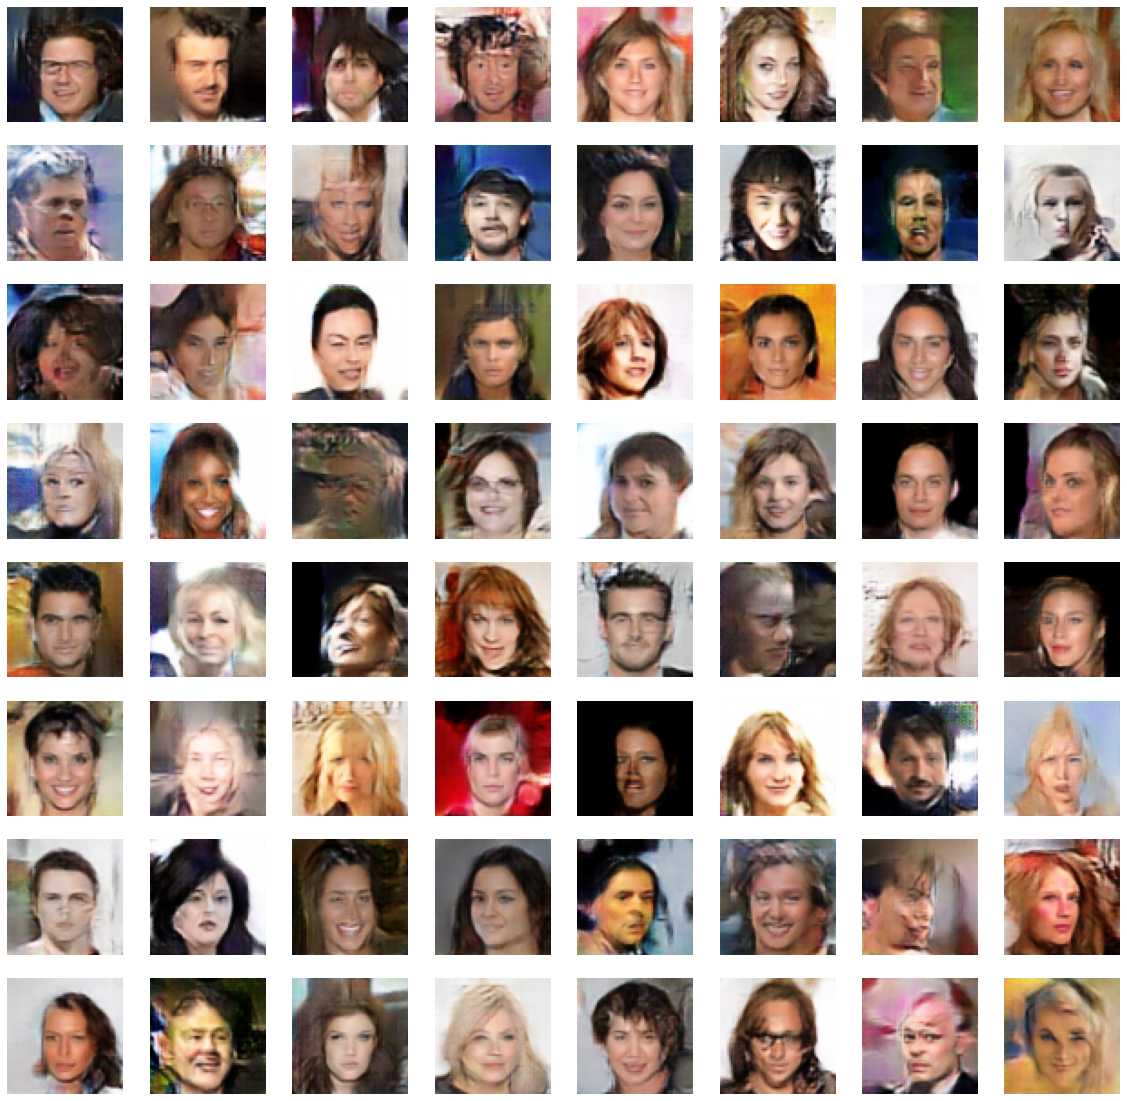

In [12]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
  img = img_list[-1][k]
  ax = fig.add_subplot(8, 8, k+1)
  ax.imshow(ImgForPlot(img))
  ax.axis("off")

plt.show()

### Plot losses of generator and discriminator

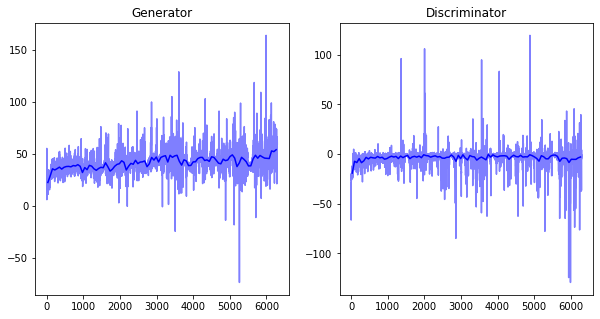

In [15]:
G_losses_ep = []
D_losses_ep = []

cnt = 0
for i in range(epochs):
  G_sum, D_sum = 0.0, 0.0
  for j in range(63):
    G_sum += G_losses[cnt]
    D_sum += D_losses[cnt]
    cnt += 1
  G_losses_ep.append(G_sum/63.0)
  D_losses_ep.append(D_sum/63.0)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(G_losses)), G_losses, c=[0, 0, 1, 0.5])
ax.plot(range(31, len(G_losses)+31, 63), G_losses_ep, c=[0, 0, 1, 1])
ax.set_title("Generator")
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(len(D_losses)), D_losses, c=[0, 0, 1, 0.5])
ax.plot(range(31, len(D_losses)+31, 63), D_losses_ep, c=[0, 0, 1, 1])
ax.set_title("Discriminator")

plt.show()

## Save models and images in drive

In [16]:
model_name = 'WGAN-GP_CelebA'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
noise_path = F"{model_saved_dir}/{model_name}_noise.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

torch.save(netG.state_dict(), G_path)
torch.save(netD.state_dict(), D_path)

with open(img_list_path, 'wb') as f:
    pickle.dump(img_list, f)
with open(losses_path, 'wb') as f:
    pickle.dump((G_losses, D_losses), f)
with open(noise_path, 'wb') as f:
    pickle.dump(fixed_noise, f)

print(F"Saved {model_name} Completed!")

Saved WGAN-GP_CelebA Completed!


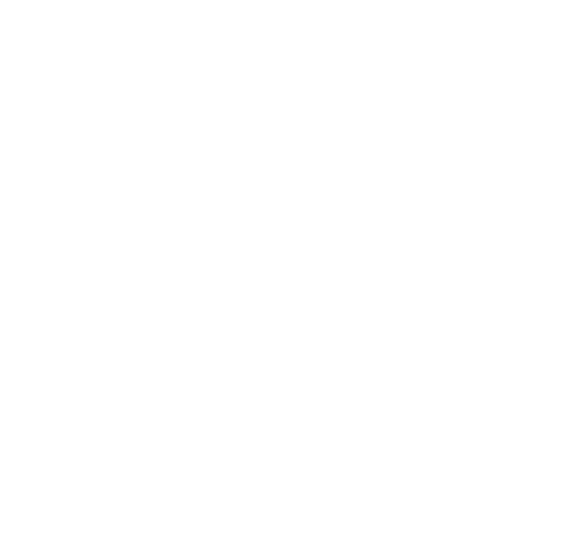

In [20]:
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from IPython.display import HTML, clear_output

rcParams['animation.embed_limit'] = 2**128

ims = []
SIZE = 10
fig = plt.figure(figsize=(SIZE, SIZE))

imgs = img_list[0].tolist()
for j in range(64):
    ax = fig.add_subplot(8, 8, j+1)
    im = ax.imshow(ImgForPlot(imgs[j]))
    ax.axis("off")
    ims.append(im)

def init():
    for j in range(64):
        ims[j].set_data([[]])

    return tuple(ims)

def update(frame):
    imgs = img_list[frame].tolist()
  
    for j in range(64):
        img = imgs[j]
        ims[j].set_array(ImgForPlot(img))

    return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=200, blit=True, frames=range(len(img_list)))

plt.show()
clear_output(wait = True)

ani.save('train.gif', writer='pillow', fps=5)

## Test

### Find latent vector of real images with backprop

In [22]:
class latent_vector(nn.Module):
    def __init__(self):
        super(latent_vector, self).__init__()
        self.z_real = nn.Parameter(torch.randn(1, nz, 1, 1, device=device))
        self.z_real.requires_grad_()

    def forward(self):
        netG.eval()
        return netG(self.z_real)


def find_latent(target_img, iterations = 10000):
    netG.eval()

    lv = latent_vector()
    optimizerZ = optim.Adam(lv.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for iter in range(iterations):
        lv.zero_grad()
        gen_img = lv()
        loss = criterion(gen_img.view(target_img.shape), target_img)
        loss.backward()
        optimizerZ.step()

    print('Loss: %.4f' % loss.item())
    return lv.z_real

Loss: 0.0372


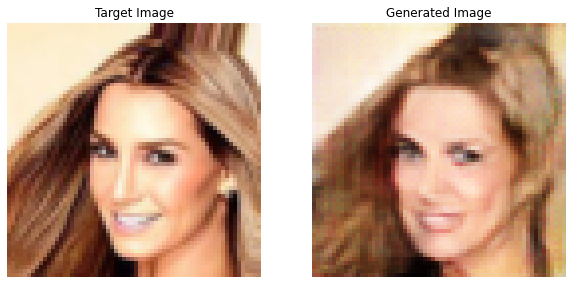

In [23]:
target_image, _ = dataset[0]
target_z = find_latent(target_image.cuda())

netG.eval()
gen_image = netG(target_z)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ImgForPlot(target_image))
ax.set_title('Target Image')
ax.axis("off")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(ImgForPlot(gen_image.squeeze_(0).cpu().detach().numpy()))
ax.set_title('Generated Image')
ax.axis("off")
plt.show()

In [32]:
netD.eval()

print('Target Image: %.4f' % netD(target_image.view(1,3,64,64).cuda()))
print('Generated Image: %.4f' % netD(gen_image.view(1,3,64,64).cuda()))

Target Image: -34.6952
Generated Image: -33.5678


### Mapping two images

In [24]:
idx1, idx2 = 0, 1

target1, _ = dataset[idx1]
target2, _ = dataset[idx2]

z1 = find_latent(target1.cuda())
z2 = find_latent(target2.cuda())

Loss: 0.0379
Loss: 0.0338


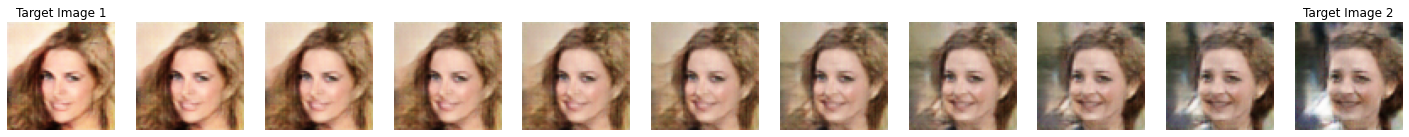

In [25]:
netG.eval()
imgs = []
for i in range(11):
    alpha = i * 0.1
    z = z1 * (1.0 - alpha) + z2 * alpha
    img = netG(z)
    imgs.append(img.squeeze_(0).cpu().detach().numpy())

fig = plt.figure(figsize=(25, 4))
for i in range(11):
    ax = fig.add_subplot(1, 11, i+1)
    ax.imshow(ImgForPlot(imgs[i]))
    if i == 0:
        ax.set_title('Target Image 1')
    elif i == 10:
        ax.set_title('Target Image 2')
    ax.axis("off")

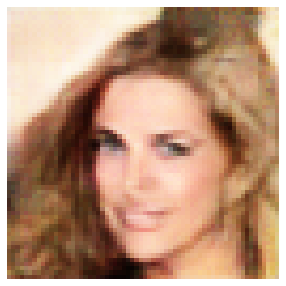

In [27]:
netG.eval()
n_imgs = 100
imgs = []
for i in range(n_imgs+1):
    alpha = i * 1.0 / n_imgs
    z = z1 * (1.0 - alpha) + z2 * alpha
    img = netG(z)
    imgs.append(img.squeeze_(0).cpu().detach().numpy())

SIZE = 5
fig = plt.figure(figsize=(SIZE, SIZE))

im = plt.imshow(ImgForPlot(imgs[0]))
plt.axis('off')

def init():
    im.set_data(ImgForPlot(imgs[0]))
    return [im]

def update(frame):
    img = imgs[frame].tolist()
    im.set_array(ImgForPlot(img))

    return [im]

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=int(5000/n_imgs), blit=True, frames=range(n_imgs+1))

plt.show()
clear_output(wait = True)

ani.save('test.gif', writer='pillow', fps=30)

### Mapping several images

In [34]:
idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

zs = []
for idx in idxs:
    target, _ = dataset[idx]
    zs.append(find_latent(target.cuda()))

Loss: 0.0403
Loss: 0.0338
Loss: 0.0118
Loss: 0.0222
Loss: 0.0361
Loss: 0.0231
Loss: 0.0253
Loss: 0.0274
Loss: 0.0236
Loss: 0.0193


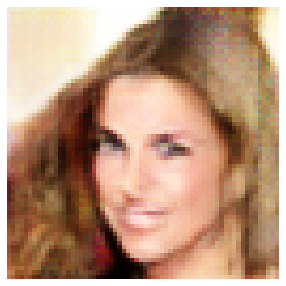

In [35]:
n_imgs_stop = 20
n_imgs_change = 60
SIZE = 5
    
netG.eval()
imgs = []

img = netG(zs[0]).squeeze_(0)
for i in range(n_imgs_stop):
    imgs.append(img.cpu().detach().numpy())

for j in range(len(zs)-1):
    for i in range(n_imgs_change):
        alpha = i * 1.0 / n_imgs_change
        z = zs[j] * (1.0 - alpha) + zs[j+1] * alpha
        img = netG(z).squeeze_(0)
        imgs.append(img.cpu().detach().numpy())
        
    img = netG(zs[j+1]).squeeze_(0)
    for i in range(n_imgs_stop):
        imgs.append(img.cpu().detach().numpy())

for i in range(n_imgs_change):
    alpha = i * 1.0 / n_imgs_change
    z = zs[-1] * (1.0 - alpha) + zs[0] * alpha
    img = netG(z).squeeze_(0)
    imgs.append(img.cpu().detach().numpy())

fig = plt.figure(figsize=(SIZE, SIZE))

im = plt.imshow(ImgForPlot(imgs[0]))
plt.axis('off')

def init():
    im.set_data(ImgForPlot(imgs[0]))
    return [im]

def update(frame):
    img = imgs[frame].tolist()
    im.set_array(ImgForPlot(img))

    return [im]

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=int(5000/len(imgs)), blit=True, frames=range(len(imgs)))

plt.show()
clear_output(wait = True)

ani.save('test.gif', writer='pillow', fps=30)